Introduction
In this notebook, we will explore and build a machine learning model for stock price prediction. The goal is to use historical stock data to train an LSTM model that can forecast future stock prices. We will go through data preparation, model training, evaluation, and visualization, following best practices for data science and machine learning.
LSTM (Long Short-Term Memory) networks were chosen for this stock price prediction task due to their effectiveness in handling sequential data and capturing long-term dependencies. 

In this cell, we import all the necessary libraries required for data processing, model building, training, evaluation, and visualization.

In [98]:
# Import necessary libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import os
import json
import logging
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from bayes_opt import BayesianOptimization
import seaborn as sns

Logging is set up to capture detailed information about the execution process.

In [99]:
# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

This cell loads the configuration settings from a JSON file. The configuration file contains hyperparameters

In [100]:
# Load configuration from JSON file
def load_config(config_path='../scripts/config.json'):
    with open(config_path, 'r') as file:
        config = json.load(file)
    return config

config = load_config()
logger.info("Configuration loaded successfully.")

2024-08-08 15:57:12,348 - INFO - Configuration loaded successfully.


In [101]:
def get_stock_data(ticker, csv_filename):
    if os.path.exists(csv_filename):
        logger.info(f"Reading data from {csv_filename}")
        return pd.read_csv(csv_filename, parse_dates=['Date'])
    else:
        logger.info(f"Fetching data from yfinance API for {ticker}")
        end_date = datetime.now()
        start_date = end_date - timedelta(days=5 * 365)  # 5 years of data
        data = yf.download(ticker, start=start_date, end=end_date)
        data = data.reset_index()
        data.to_csv(csv_filename, index=False)
        return data

# Prepare the data
def prepare_stock_data(stock_data):
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])
    stock_data = stock_data.sort_values('Date')
    return stock_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

Correlation analysis helps to understand the relationships between different features (e.g., Open, High, Low, Close, Volume).

In [102]:
def plot_correlation_matrix(tickers):
    for ticker in tickers:
        csv_filename = f"../data/{ticker}_stock_data.csv"
        data = get_stock_data(ticker, csv_filename)
        stock_data = prepare_stock_data(data)

        # Correlation matrix
        correlation_matrix = stock_data.iloc[:, 1:].corr()

        # Plot the correlation matrix
        plt.figure(figsize=(10, 8))
        plt.title(f'Correlation Matrix for {ticker}')
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
        plt.show()



Understanding the basic statistics of the stock data is crucial for identifying patterns and potential issues.

In [103]:
def summarize_data(tickers):
    for ticker in tickers:
        csv_filename = f"../data/{ticker}_stock_data.csv"
        data = get_stock_data(ticker, csv_filename)
        stock_data = prepare_stock_data(data)

        # Statistical summary
        summary = stock_data.describe()
        print(f"Statistical Summary for {ticker}:\n", summary)
        print("\n" + "="*80 + "\n")


In [104]:
# Function to explore and visualize data
def explore_data(tickers):
    for ticker in tickers:
        csv_filename = f"../data/{ticker}_stock_data.csv"
        data = get_stock_data(ticker, csv_filename)
        stock_data = prepare_stock_data(data)

        # Plotting stock data
        plt.figure(figsize=(14, 7))
        plt.plot(stock_data['Date'], stock_data['Close'], label=f'{ticker} Close Price')
        plt.title(f'{ticker} Stock Price Over Time')
        plt.xlabel('Date')
        plt.ylabel('Close Price ($)')
        plt.legend()
        plt.grid(True)
        plt.show()

Volatility can indicate the risk associated with the stock. High volatility might make predictions less reliable, so it's important to analyze this aspect.

In [105]:
def analyze_volatility(tickers):
    for ticker in tickers:
        csv_filename = f"../data/{ticker}_stock_data.csv"
        data = get_stock_data(ticker, csv_filename)
        stock_data = prepare_stock_data(data)

        # Calculate daily returns
        stock_data['Daily Return'] = stock_data['Close'].pct_change()

        # Calculate rolling volatility
        stock_data['Rolling Volatility'] = stock_data['Daily Return'].rolling(window=30).std()

        # Plot rolling volatility
        plt.figure(figsize=(14, 7))
        plt.plot(stock_data['Date'], stock_data['Rolling Volatility'], label='Rolling Volatility')
        plt.title(f'{ticker} Rolling Volatility')
        plt.xlabel('Date')
        plt.ylabel('Volatility')
        plt.legend()
        plt.grid(True)
        plt.show()

Step 1:Load stock tickers from configuration. These tickers represent the stocks under consideration for analysis.

Step 2: Statistical Summary of the Data
Generate a statistical summary to understand the general behavior of each stock (e.g., average prices, volatility). Helps in identifying stocks that match risk tolerance.

Step 3: Correlation Analysis
Create a correlation matrix to understand relationships between features. Helps in feature selection and choosing stocks with low correlations for better diversification.

Step 4: Data Exploration
Visualize trends, seasonality, and anomalies in the data. This step is crucial for understanding the dynamics of each stock and identifying potential opportunities.

Step 5: Volatility Analysis
Analyze rolling volatility to gauge the risk associated with each stock. Helps in selecting stocks that align with risk management strategy.

2024-08-08 15:57:12,419 - INFO - Reading data from ../data/^GSPC_stock_data.csv
2024-08-08 15:57:12,435 - INFO - Reading data from ../data/AAPL_stock_data.csv
2024-08-08 15:57:12,450 - INFO - Reading data from ../data/GOOG_stock_data.csv
2024-08-08 15:57:12,466 - INFO - Reading data from ../data/MSFT_stock_data.csv
2024-08-08 15:57:12,482 - INFO - Reading data from ../data/NVDA_stock_data.csv
2024-08-08 15:57:12,497 - INFO - Reading data from ../data/META_stock_data.csv
2024-08-08 15:57:12,513 - INFO - Reading data from ../data/AMZN_stock_data.csv
2024-08-08 15:57:12,528 - INFO - Reading data from ../data/TSLA_stock_data.csv
2024-08-08 15:57:12,544 - INFO - Reading data from ../data/NFLX_stock_data.csv
2024-08-08 15:57:12,575 - INFO - Reading data from ../data/BABA_stock_data.csv
2024-08-08 15:57:12,591 - INFO - Reading data from ../data/V_stock_data.csv
2024-08-08 15:57:12,607 - INFO - Reading data from ../data/AMZN_stock_data.csv
2024-08-08 15:57:12,622 - INFO - Reading data from ../

Statistical Summary for ^GSPC:
                                 Date         Open         High          Low  \
count                           1256  1256.000000  1256.000000  1256.000000   
mean   2022-02-06 10:06:29.808917248  4039.424716  4063.383498  4014.023182   
min              2019-08-12 00:00:00  2290.709961  2300.729980  2191.860107   
25%              2020-11-05 18:00:00  3540.947510  3562.942566  3500.547607   
50%              2022-02-05 12:00:00  4115.310059  4138.570068  4087.664917   
75%              2023-05-08 06:00:00  4474.237549  4493.372681  4450.292480   
max              2024-08-07 00:00:00  5644.089844  5669.669922  5639.020020   
std                              NaN   685.575198   685.065309   686.527254   

             Close        Volume  
count  1256.000000  1.256000e+03  
mean   4040.078417  4.353383e+09  
min    2237.399902  1.296530e+09  
25%    3536.312500  3.727240e+09  
50%    4117.614990  4.083965e+09  
75%    4472.557617  4.705960e+09  
max    5667

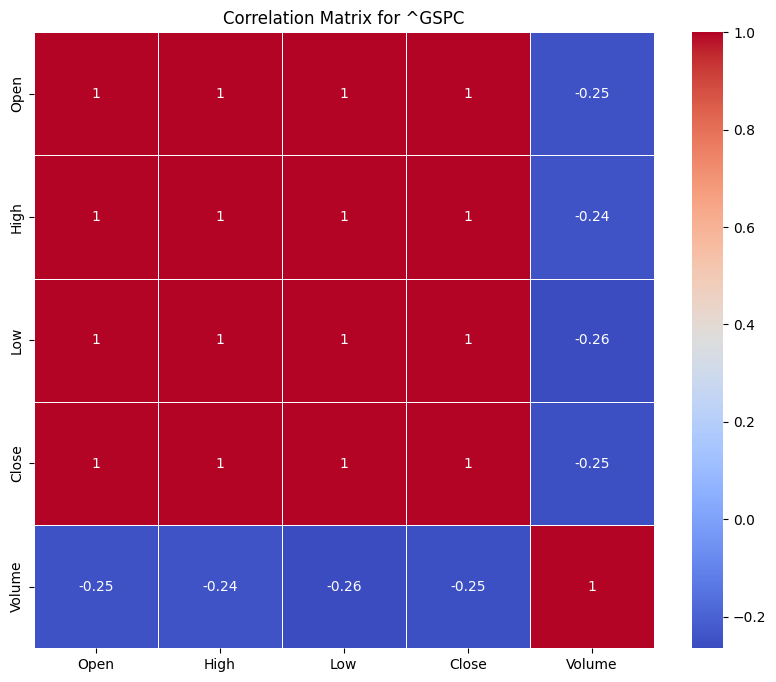

2024-08-08 15:57:12,850 - INFO - Reading data from ../data/AAPL_stock_data.csv


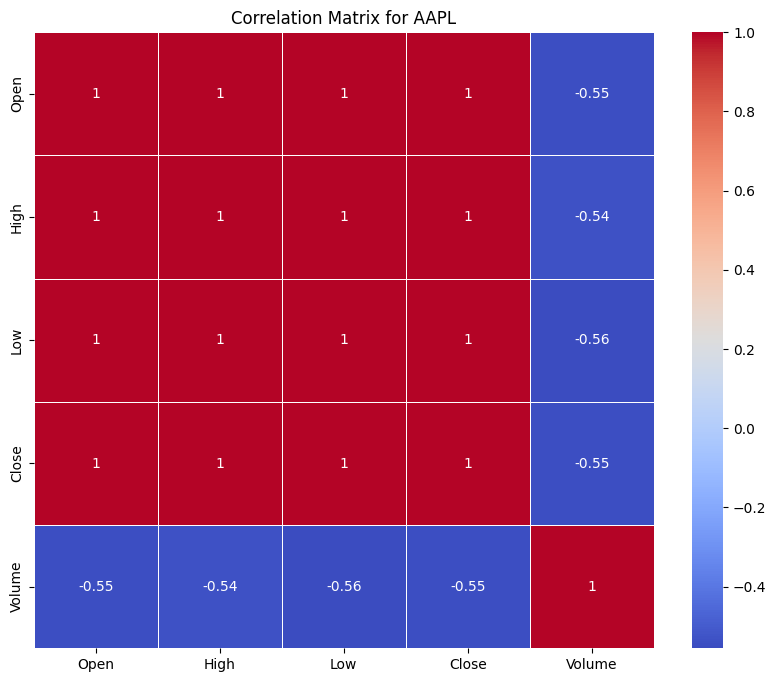

2024-08-08 15:57:13,062 - INFO - Reading data from ../data/GOOG_stock_data.csv


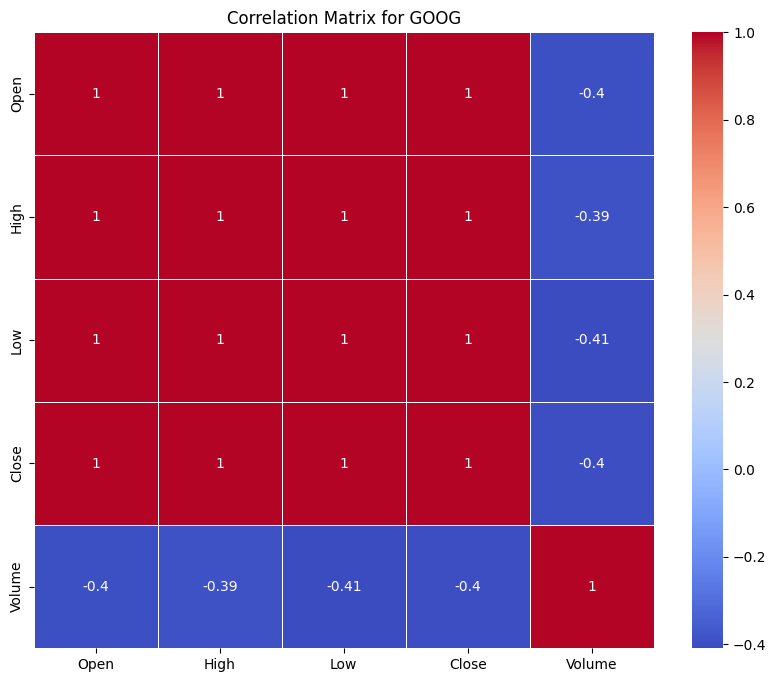

2024-08-08 15:57:13,280 - INFO - Reading data from ../data/MSFT_stock_data.csv


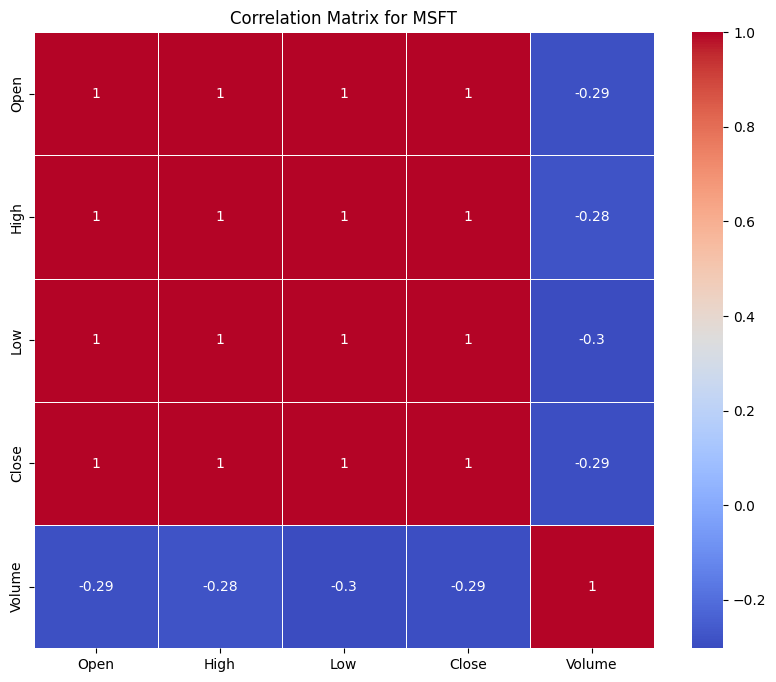

2024-08-08 15:57:13,483 - INFO - Reading data from ../data/NVDA_stock_data.csv


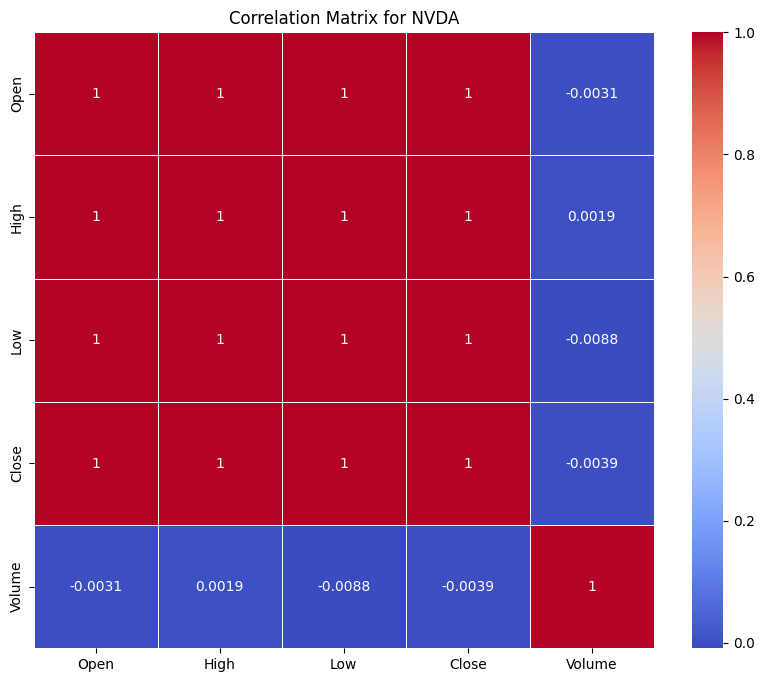

2024-08-08 15:57:13,687 - INFO - Reading data from ../data/META_stock_data.csv


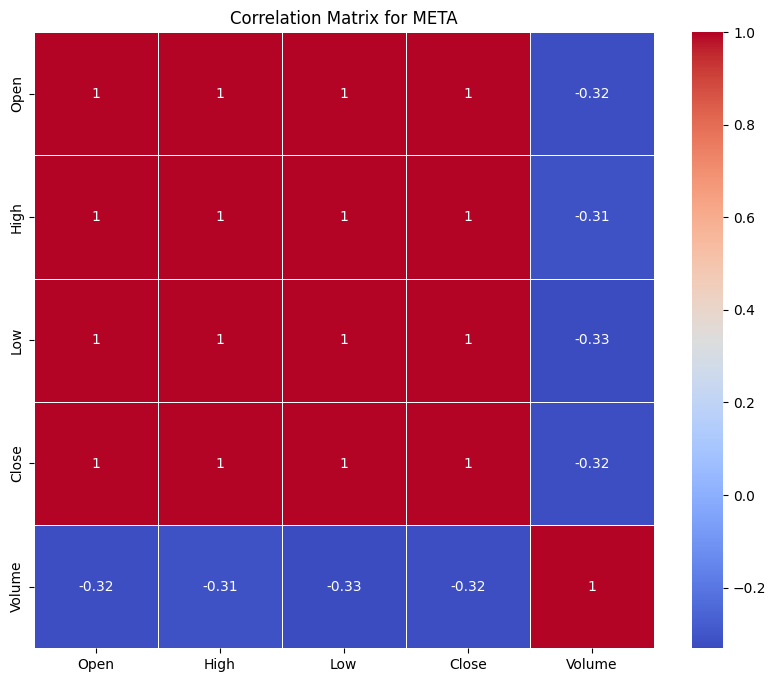

2024-08-08 15:57:13,899 - INFO - Reading data from ../data/AMZN_stock_data.csv


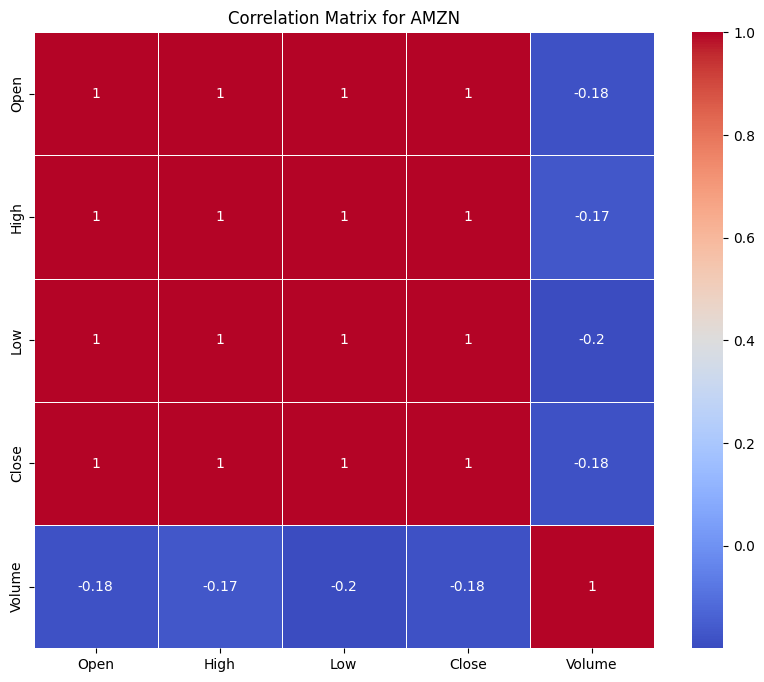

2024-08-08 15:57:14,102 - INFO - Reading data from ../data/TSLA_stock_data.csv


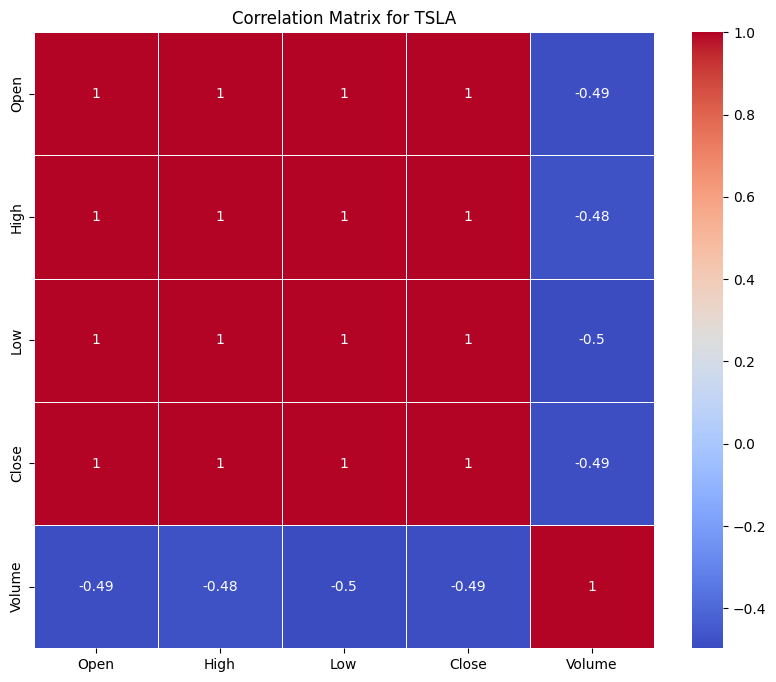

2024-08-08 15:57:14,306 - INFO - Reading data from ../data/NFLX_stock_data.csv


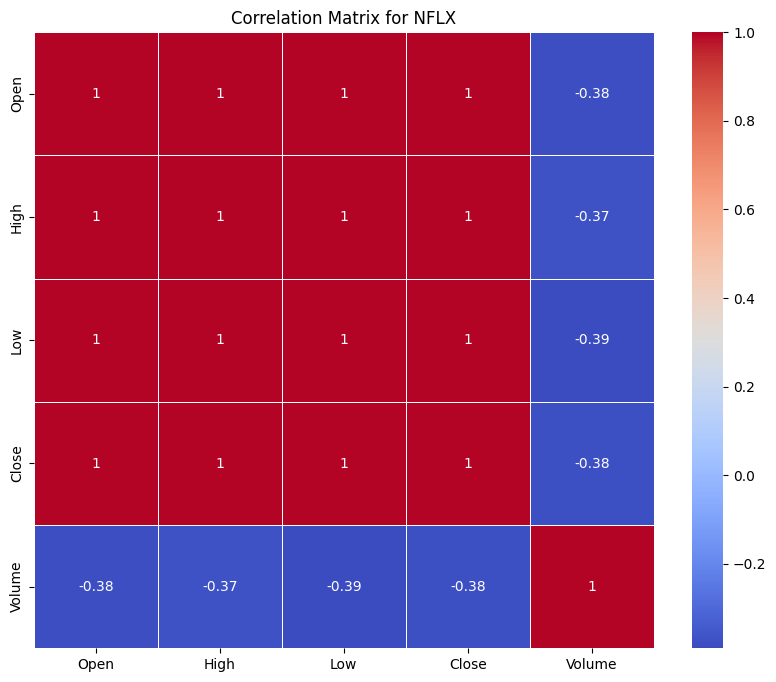

2024-08-08 15:57:14,524 - INFO - Reading data from ../data/BABA_stock_data.csv


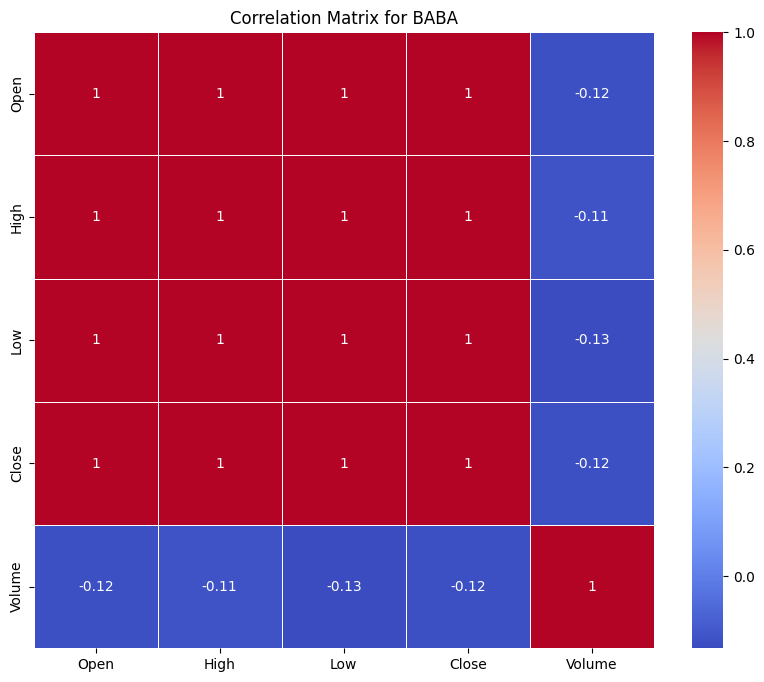

2024-08-08 15:57:14,745 - INFO - Reading data from ../data/V_stock_data.csv


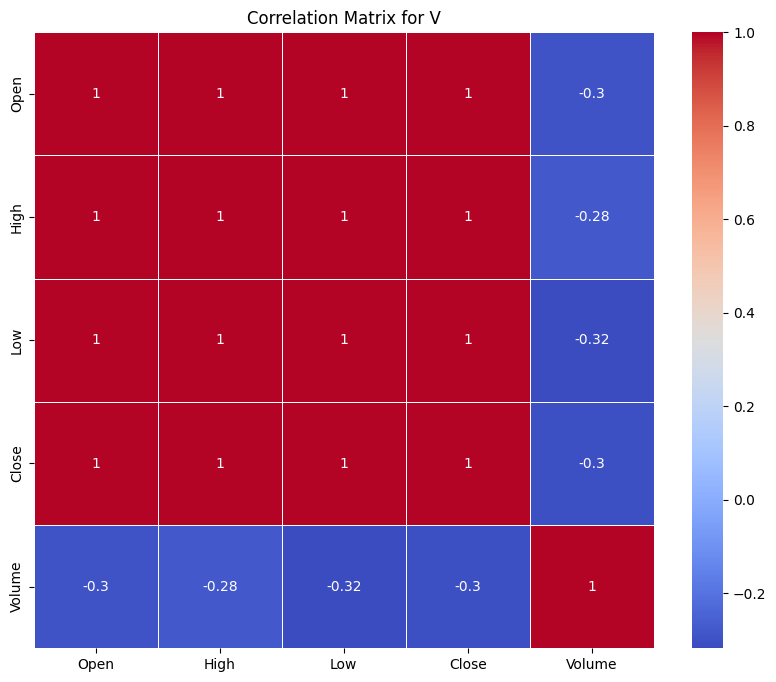

2024-08-08 15:57:15,741 - INFO - Reading data from ../data/AMZN_stock_data.csv


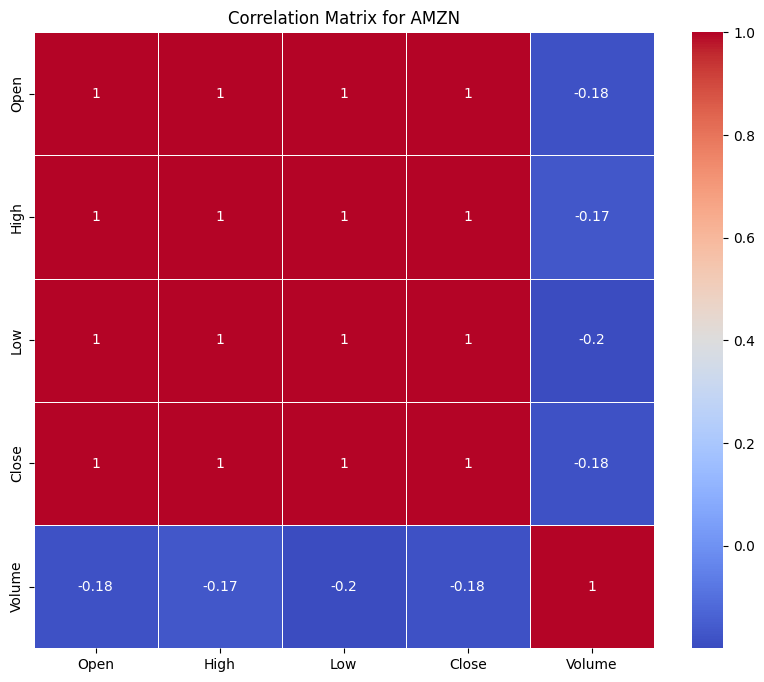

2024-08-08 15:57:15,932 - INFO - Reading data from ../data/^GSPC_stock_data.csv


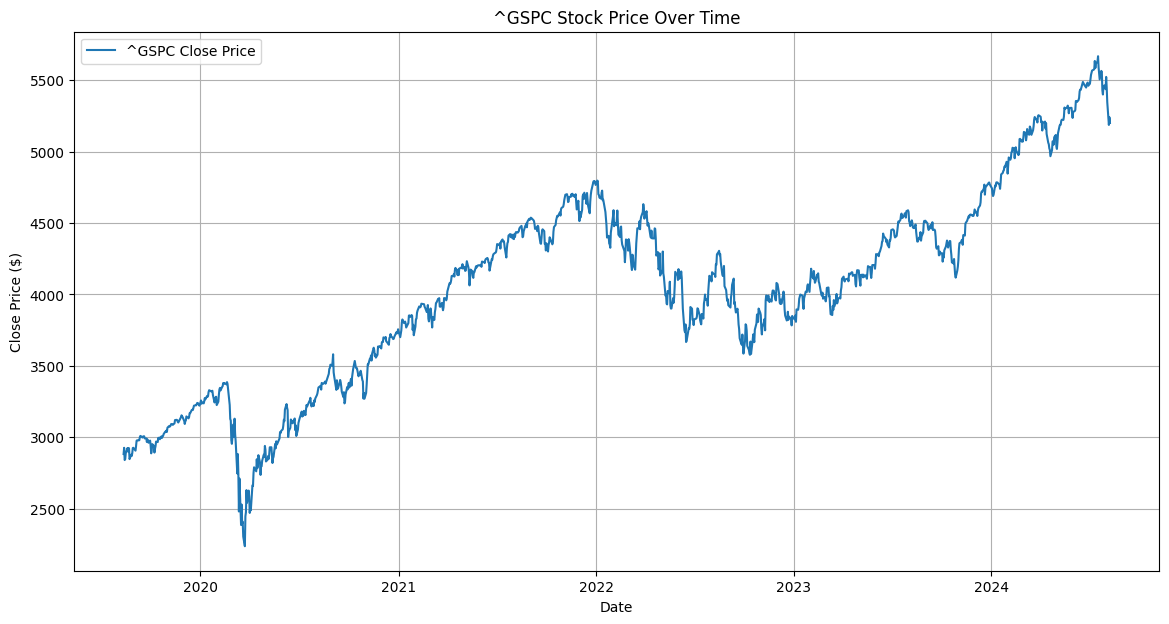

2024-08-08 15:57:16,135 - INFO - Reading data from ../data/AAPL_stock_data.csv


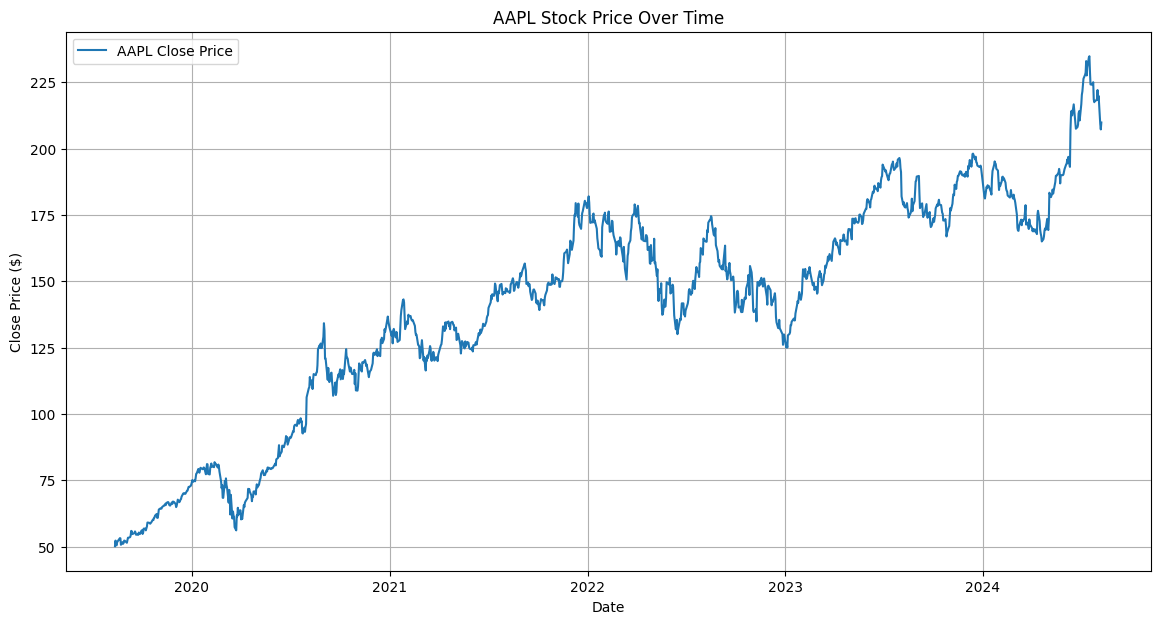

2024-08-08 15:57:16,323 - INFO - Reading data from ../data/GOOG_stock_data.csv


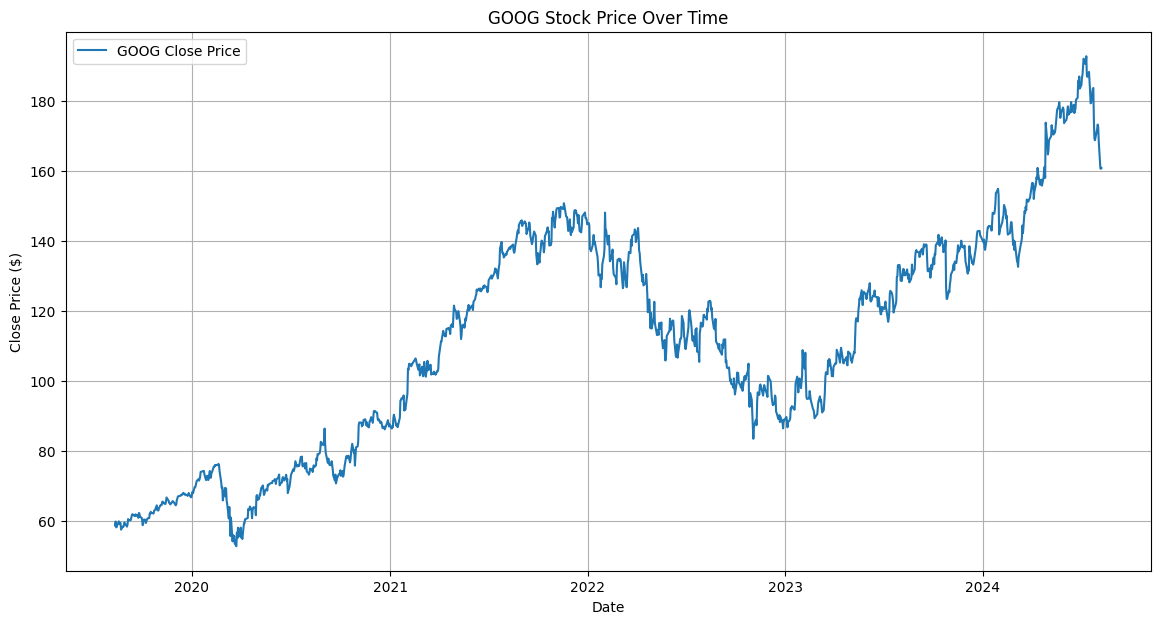

2024-08-08 15:57:16,495 - INFO - Reading data from ../data/MSFT_stock_data.csv


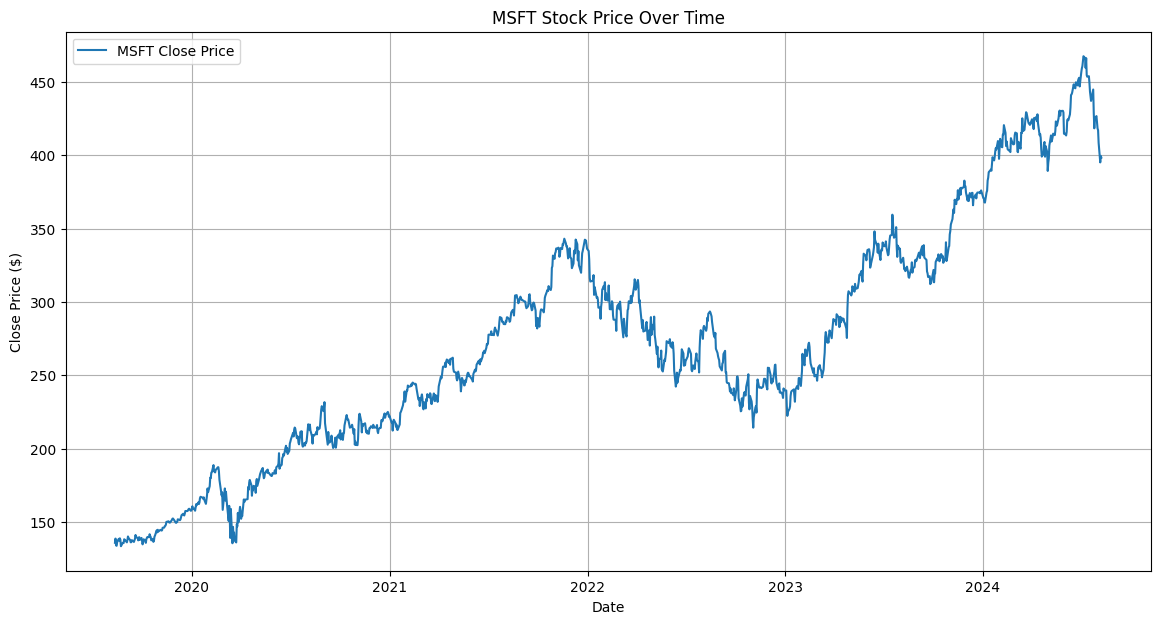

2024-08-08 15:57:16,682 - INFO - Reading data from ../data/NVDA_stock_data.csv


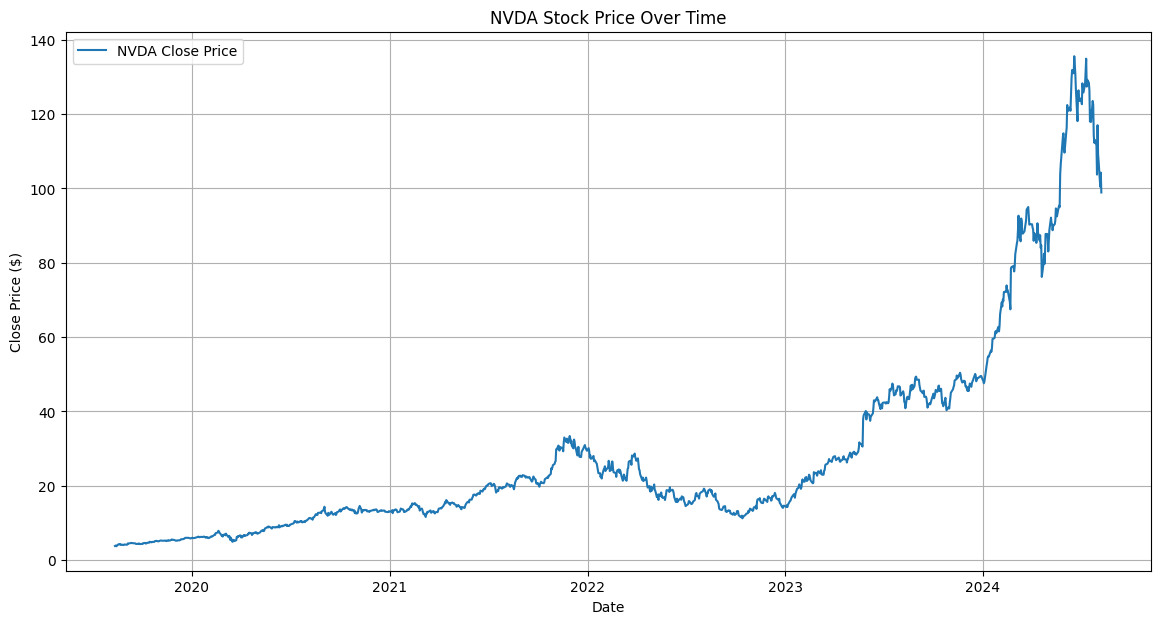

2024-08-08 15:57:16,870 - INFO - Reading data from ../data/META_stock_data.csv


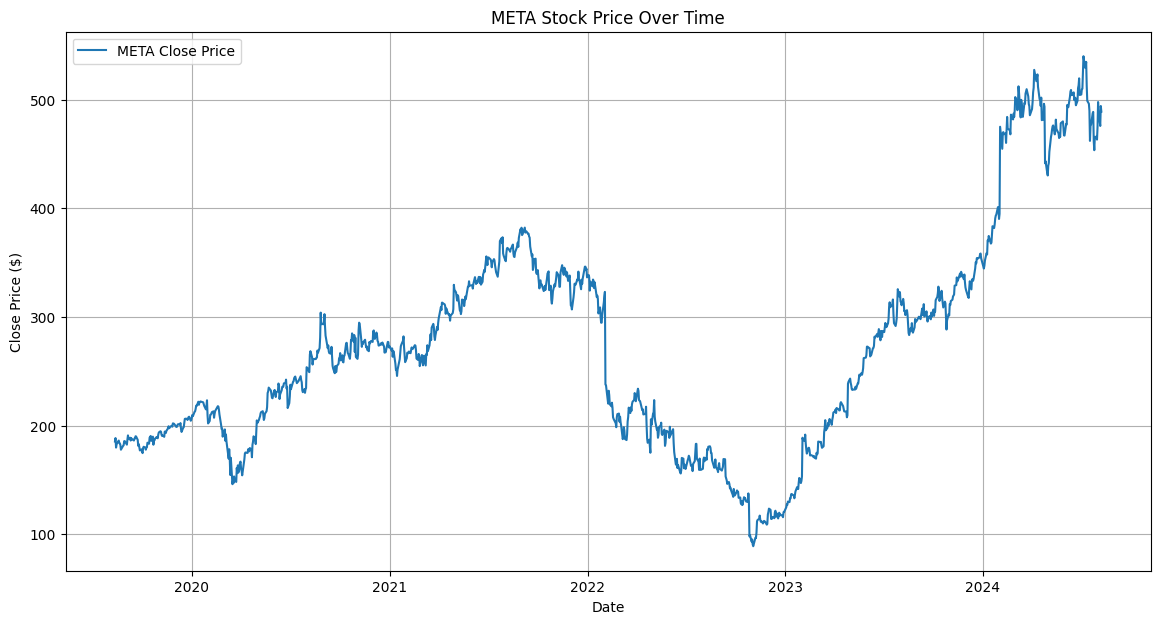

2024-08-08 15:57:17,042 - INFO - Reading data from ../data/AMZN_stock_data.csv


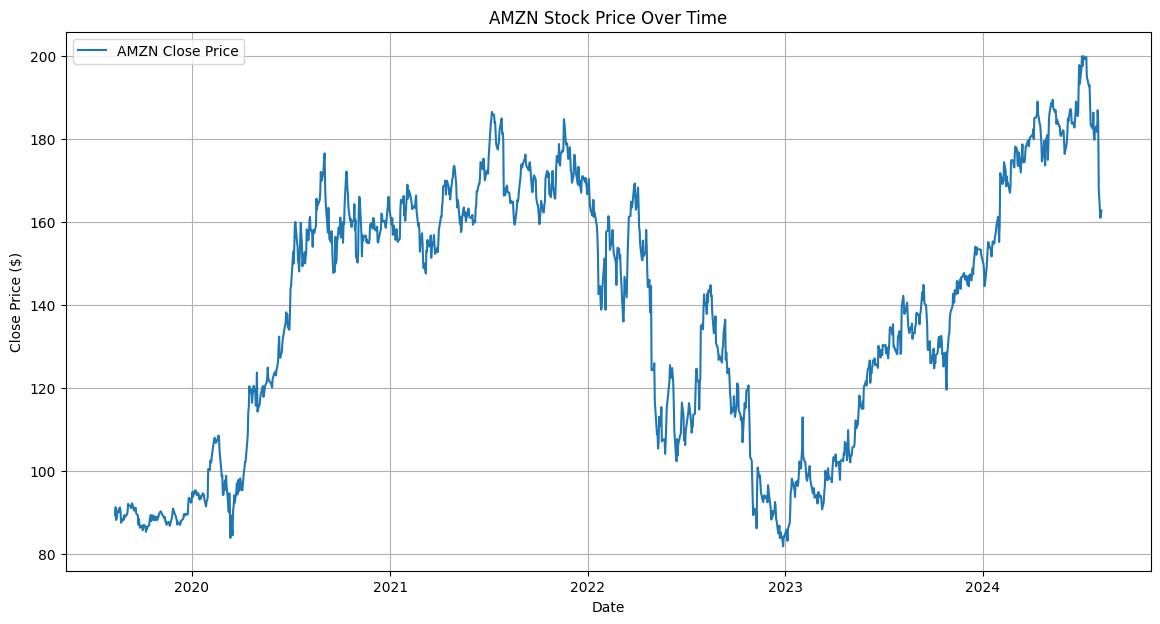

2024-08-08 15:57:17,229 - INFO - Reading data from ../data/TSLA_stock_data.csv


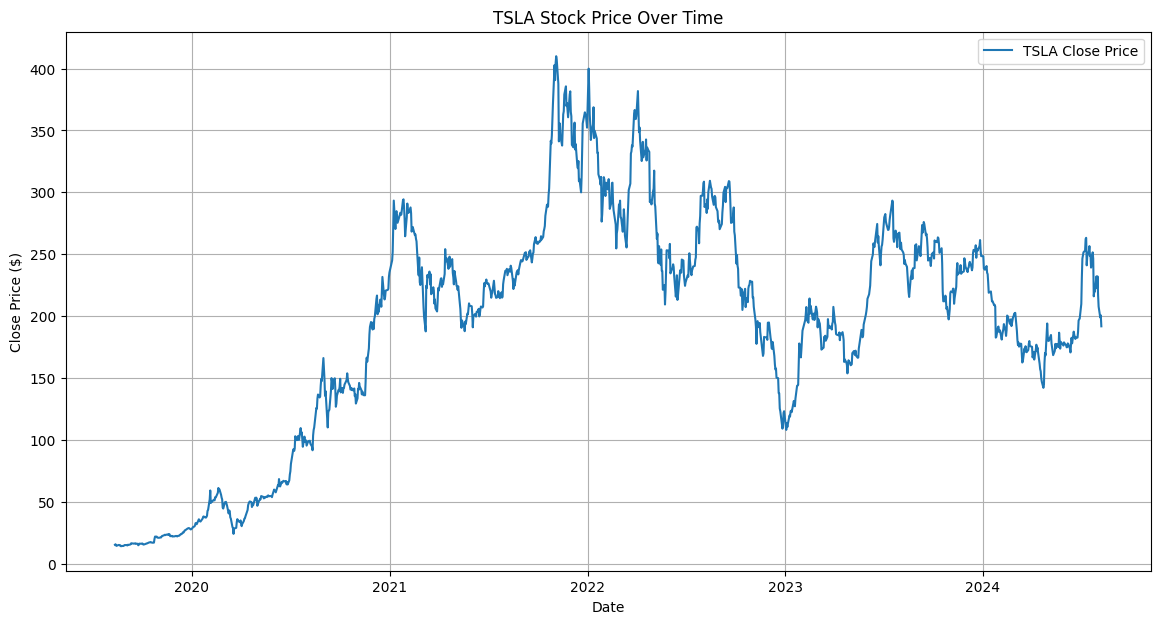

2024-08-08 15:57:17,417 - INFO - Reading data from ../data/NFLX_stock_data.csv


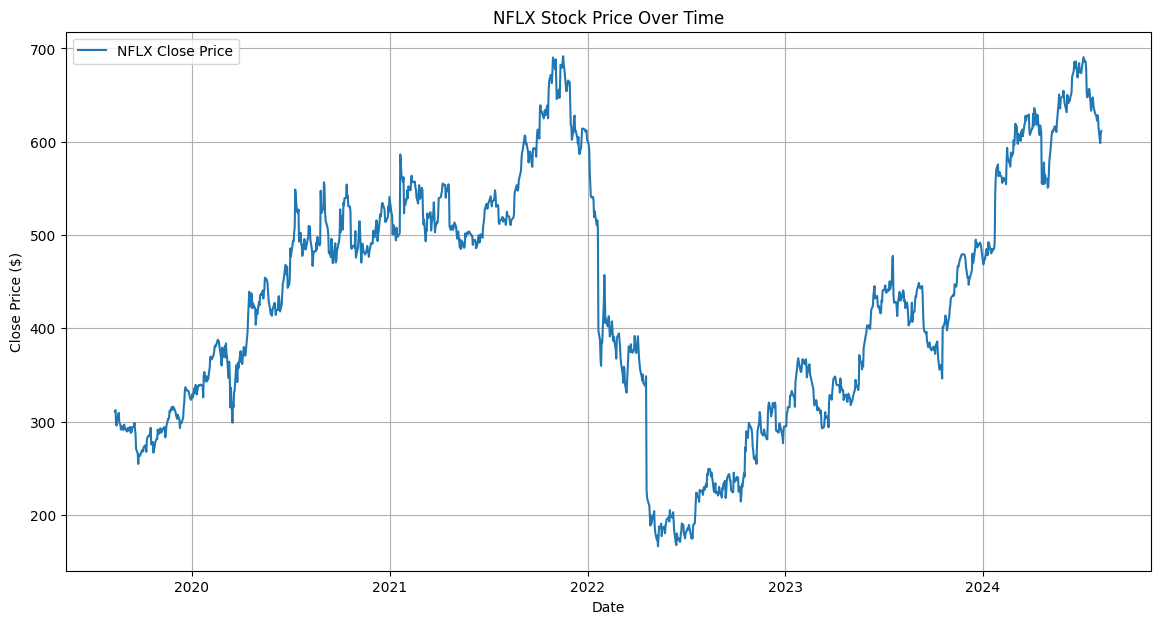

2024-08-08 15:57:17,620 - INFO - Reading data from ../data/BABA_stock_data.csv


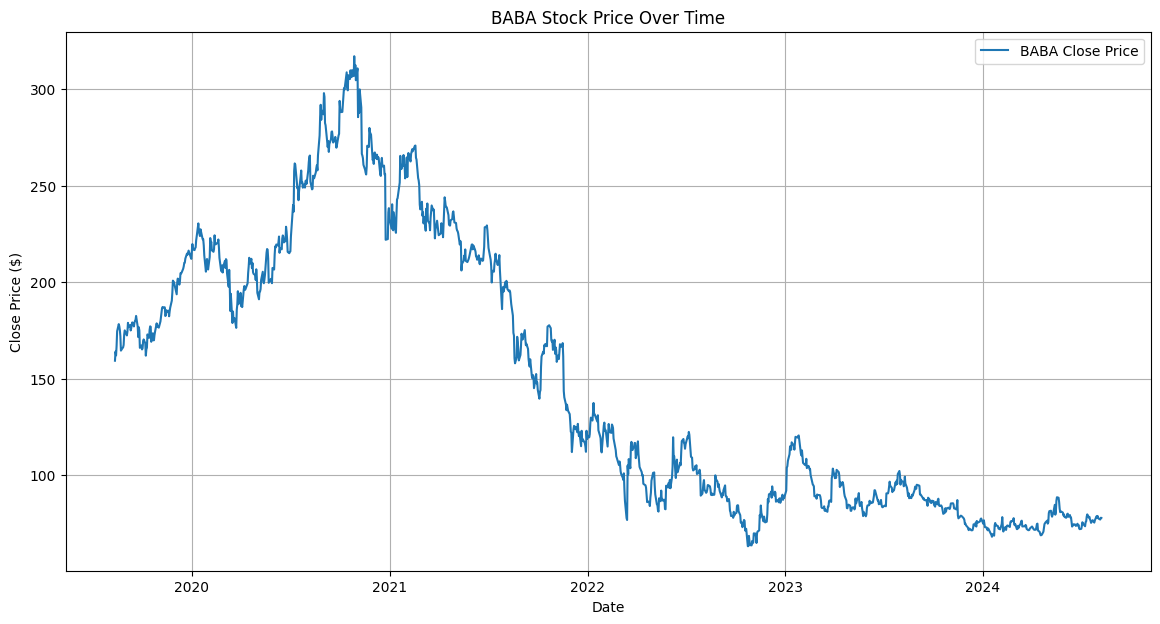

2024-08-08 15:57:17,792 - INFO - Reading data from ../data/V_stock_data.csv


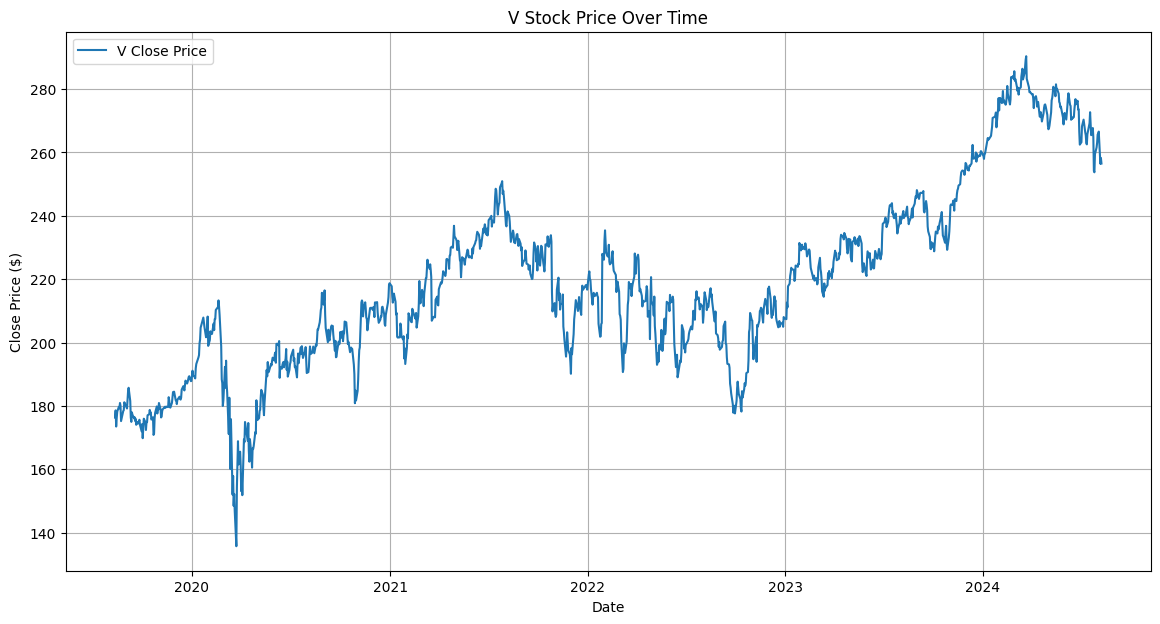

2024-08-08 15:57:18,010 - INFO - Reading data from ../data/AMZN_stock_data.csv


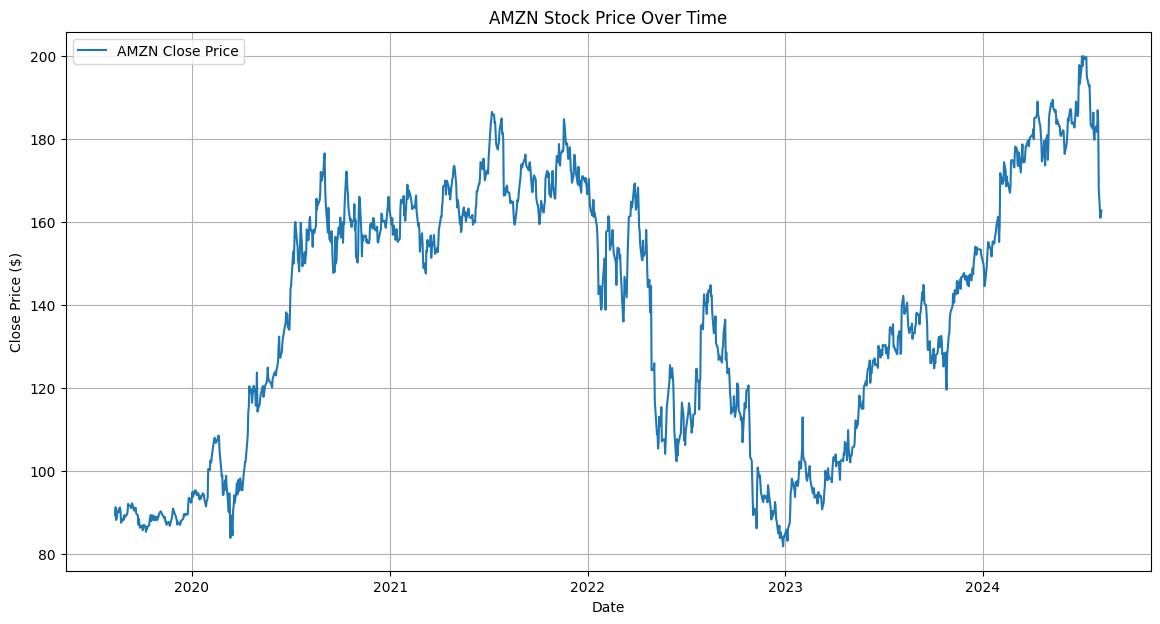

2024-08-08 15:57:18,198 - INFO - Reading data from ../data/^GSPC_stock_data.csv


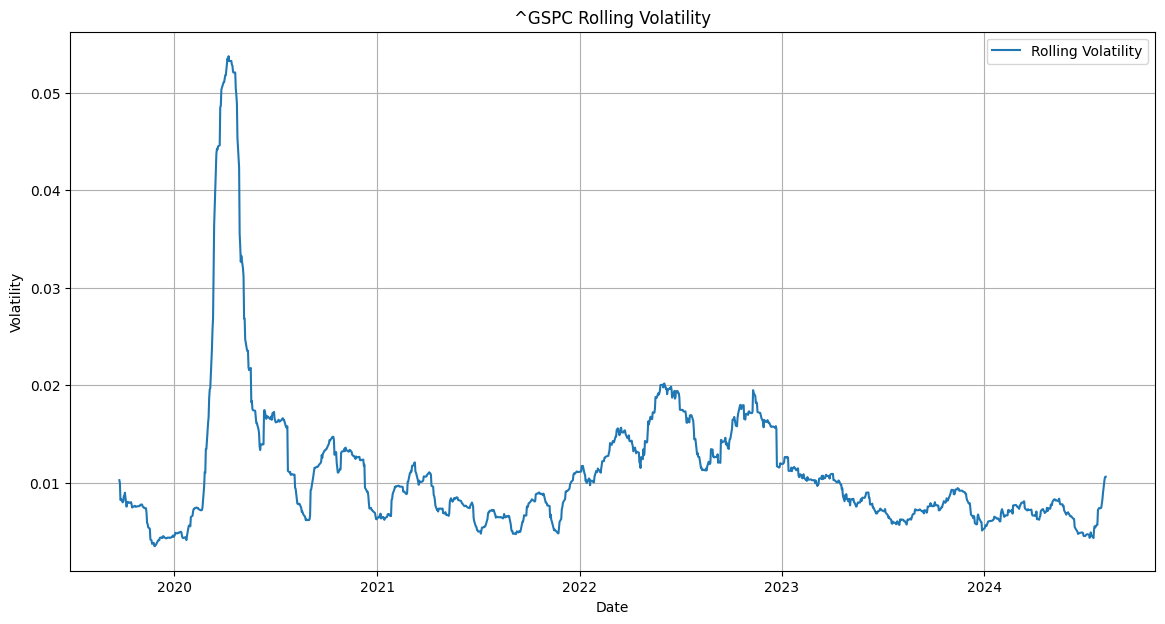

2024-08-08 15:57:18,379 - INFO - Reading data from ../data/AAPL_stock_data.csv


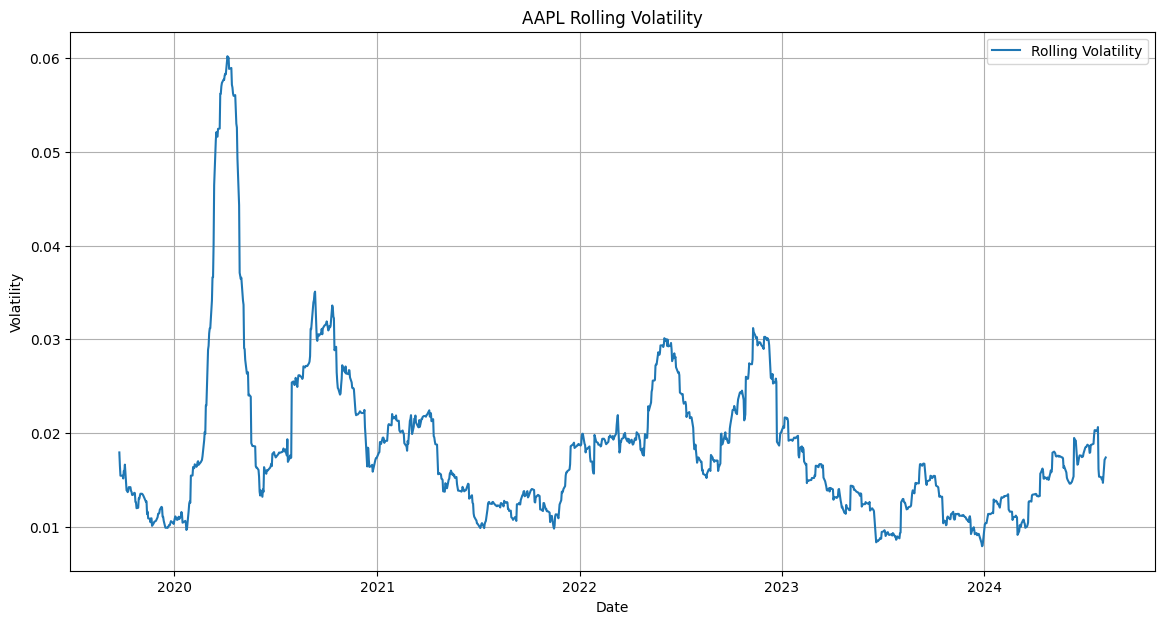

2024-08-08 15:57:18,551 - INFO - Reading data from ../data/GOOG_stock_data.csv


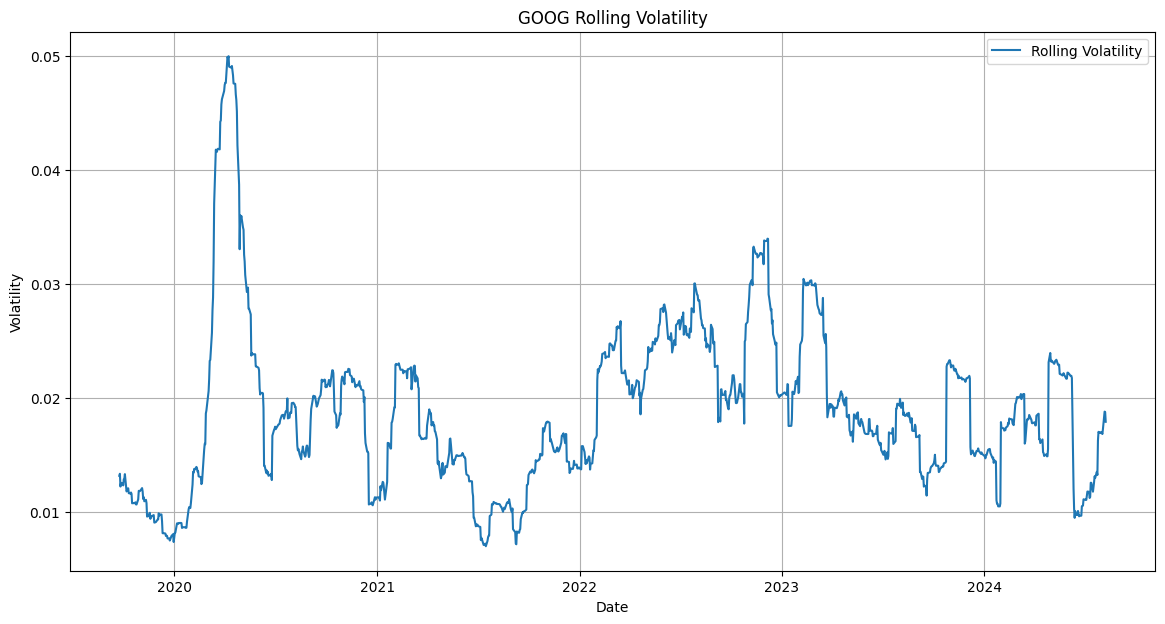

2024-08-08 15:57:18,738 - INFO - Reading data from ../data/MSFT_stock_data.csv


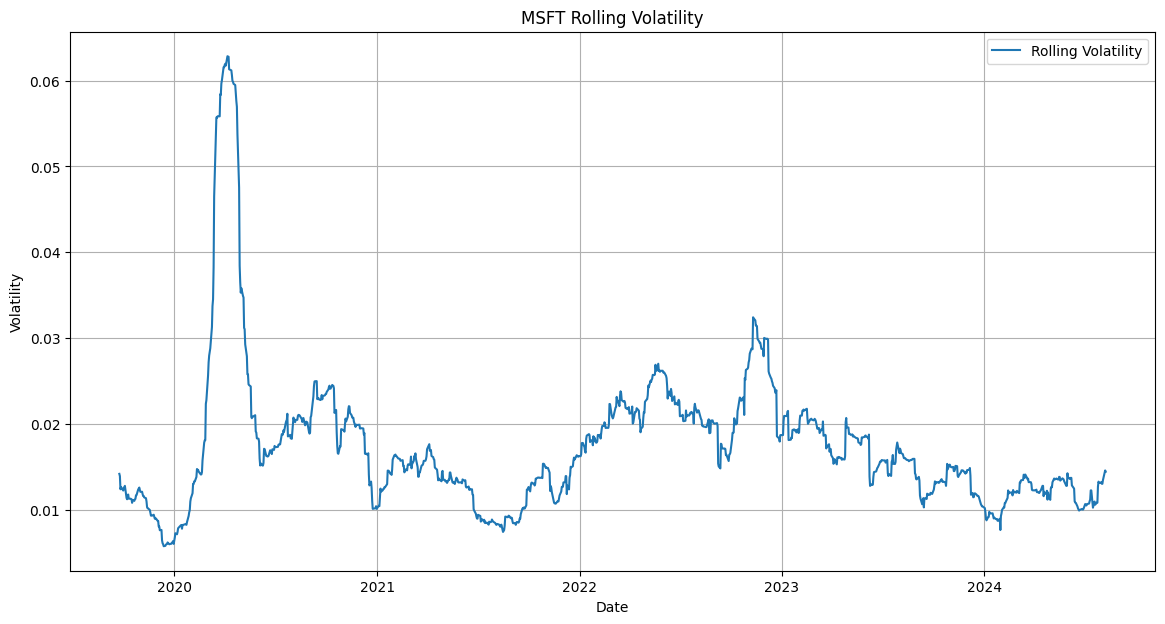

2024-08-08 15:57:18,910 - INFO - Reading data from ../data/NVDA_stock_data.csv


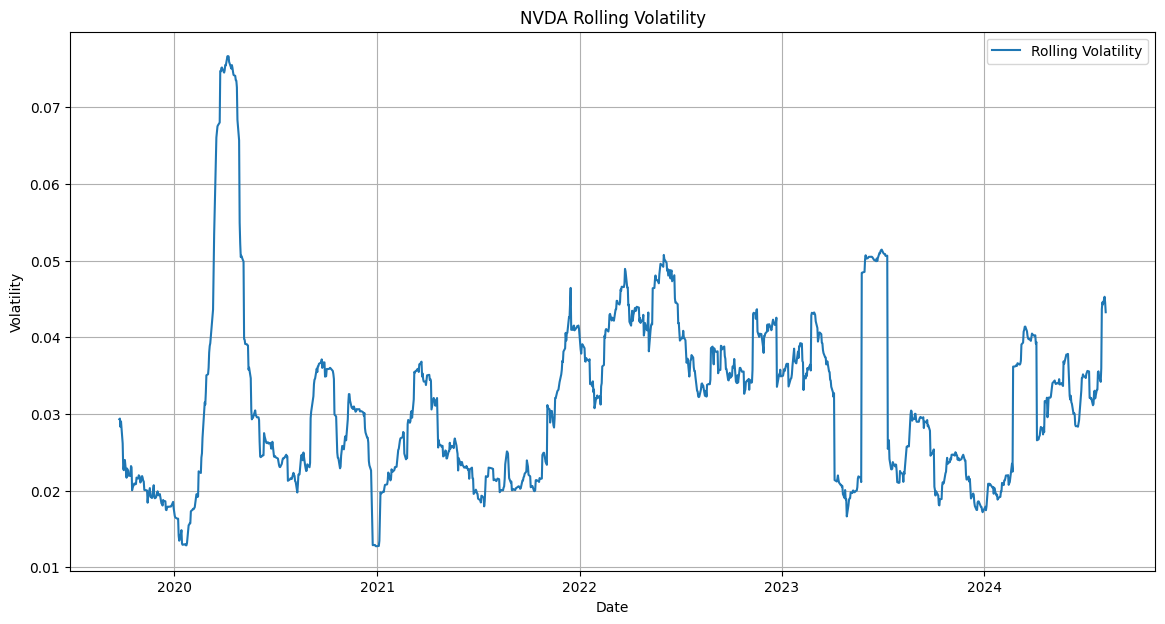

2024-08-08 15:57:19,113 - INFO - Reading data from ../data/META_stock_data.csv


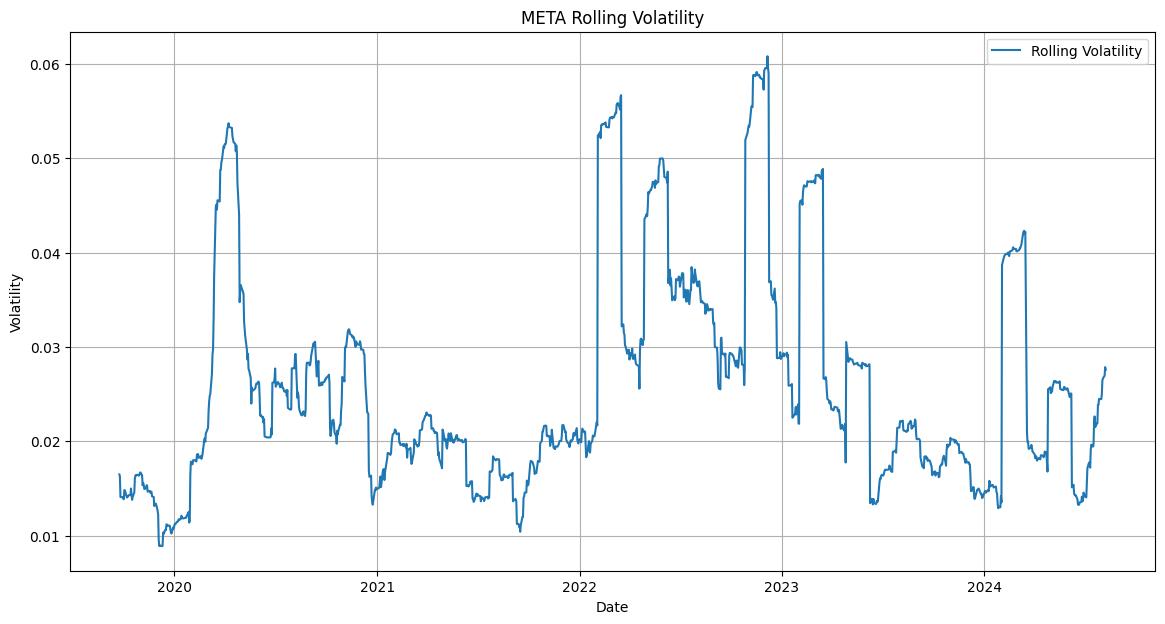

2024-08-08 15:57:19,317 - INFO - Reading data from ../data/AMZN_stock_data.csv


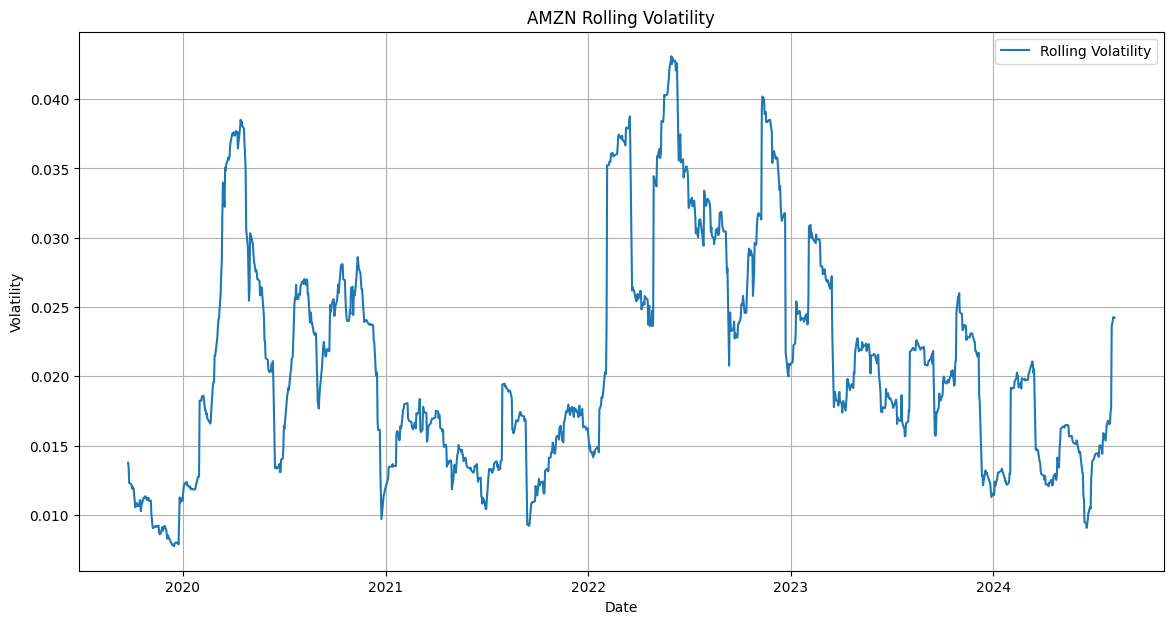

2024-08-08 15:57:19,504 - INFO - Reading data from ../data/TSLA_stock_data.csv


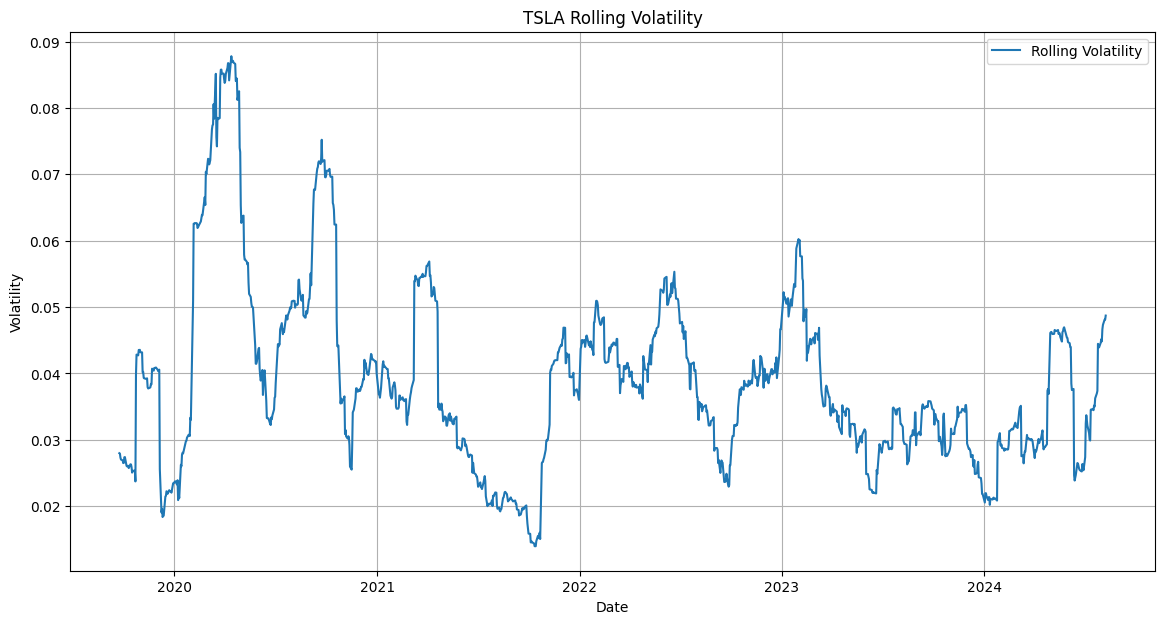

2024-08-08 15:57:19,707 - INFO - Reading data from ../data/NFLX_stock_data.csv


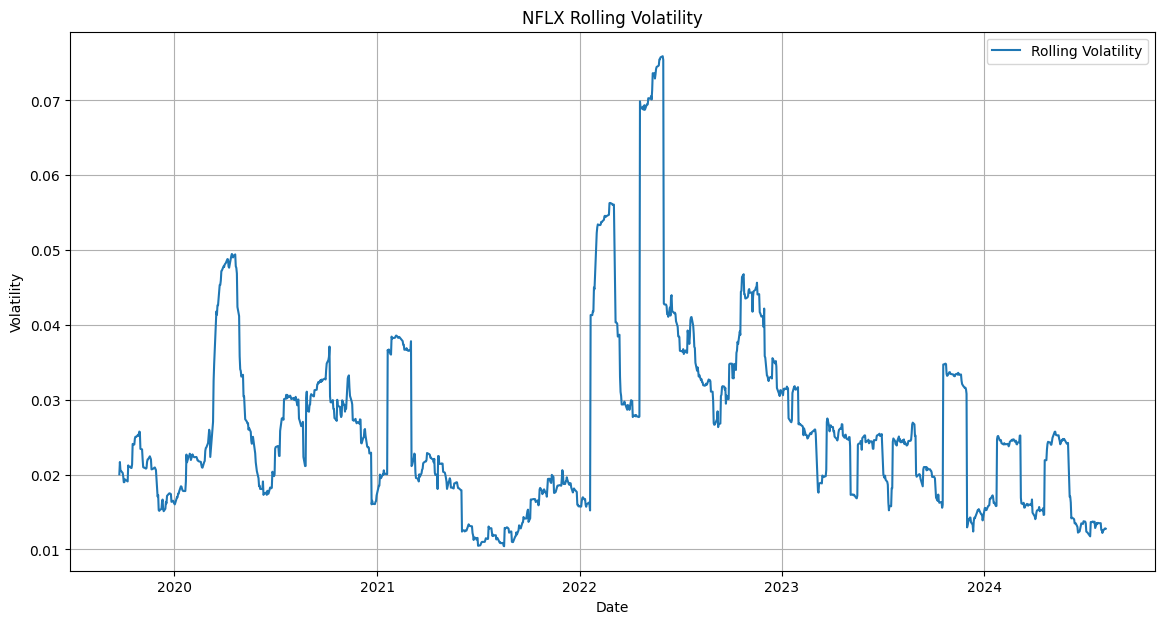

2024-08-08 15:57:19,895 - INFO - Reading data from ../data/BABA_stock_data.csv


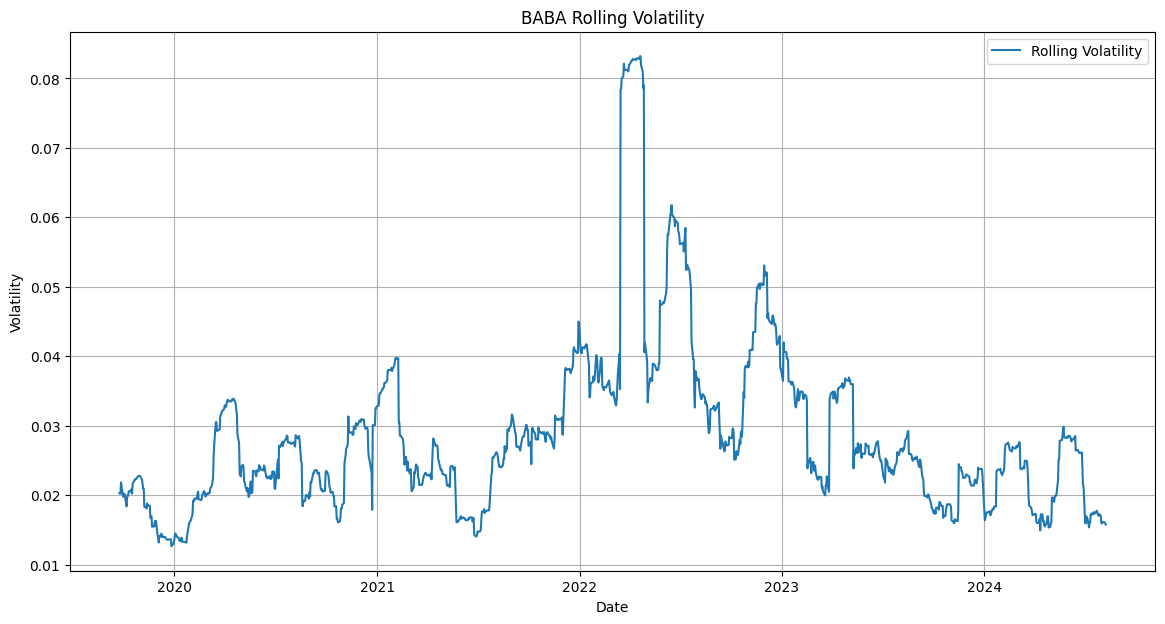

2024-08-08 15:57:20,082 - INFO - Reading data from ../data/V_stock_data.csv


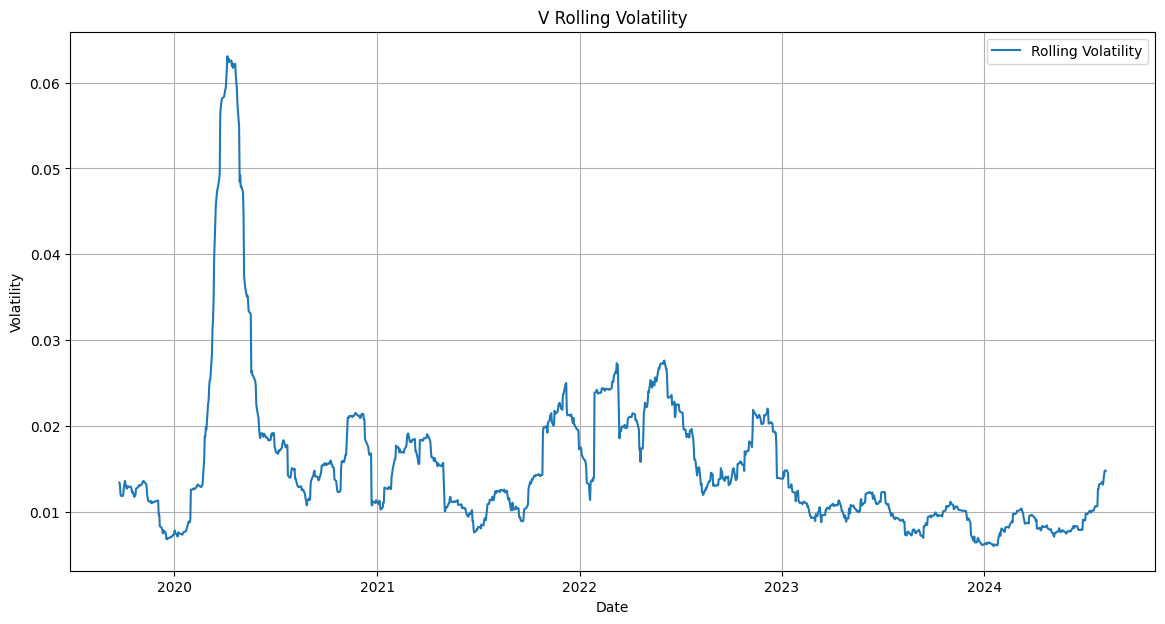

2024-08-08 15:57:20,270 - INFO - Reading data from ../data/AMZN_stock_data.csv


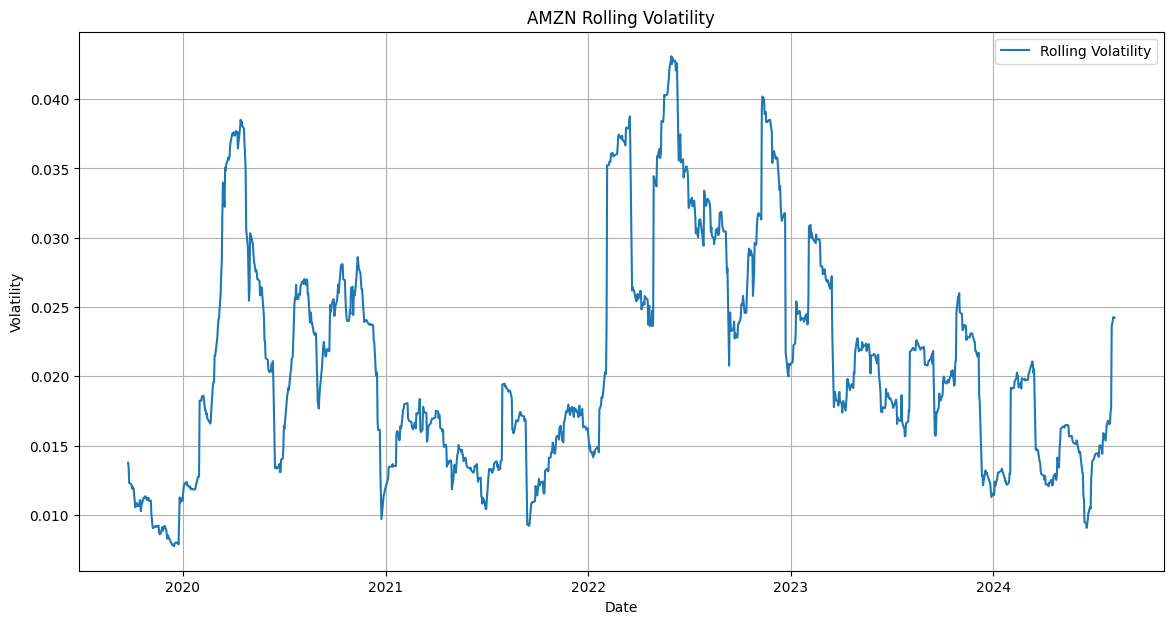

In [106]:
tickers = load_config()["tikets"]
summarize_data(tickers)
plot_correlation_matrix(tickers)
explore_data(tickers)
analyze_volatility(tickers)

To train the LSTM model, we need to convert our stock data into sequences. This cell defines a function that creates input sequences and corresponding labels. This step is critical as LSTM models require sequential data to capture temporal dependencies.

In [107]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length, 3])  # Predicting the 'Close' price
    return np.array(X), np.array(y)

The StockModel class is introduced here. 

In [108]:
class StockModel:
    def __init__(self, tickers, continue_training=False):
        self.tickers = tickers
        self.continue_training = continue_training
        self.scalers = {}
        self.stock_data_dict = {}
        self.X_train = np.array([])
        self.y_train = np.array([])
        self.X_test = np.array([])
        self.y_test = np.array([])
        self.best_params = {}
        self.history = None

    def load_or_optimize_params(self):
        params_path = '../scripts/best_params.json'
        if os.path.exists(params_path):
            with open(params_path, 'r') as f:
                self.best_params = json.load(f)
            logger.info("Loaded existing parameters")
        else:

            def lstm_stock_model(learning_rate, batch_size, dropout_rate):
                model = self.create_model((7, 5), learning_rate, dropout_rate)
                self.history = model.fit(
                    self.X_train, self.y_train,
                    epochs=config['epochs'],
                    batch_size=int(batch_size),
                    validation_split=load_config()["validation_split"],
                    verbose=0,
                    callbacks=[EarlyStopping(patience=10), ReduceLROnPlateau(patience=5)]
                )
                return -self.history.history['val_loss'][-1]

            pbounds = {
                'learning_rate': (1e-4, 1e-2),
                'batch_size': (16, 128),
                'dropout_rate': (0.1, 0.5)
            }

            optimizer = BayesianOptimization(
                f=lstm_stock_model,
                pbounds=pbounds,
                random_state=42,
                verbose=2
            )

            optimizer.maximize(init_points=config['init_points'], n_iter=config['n_iter'])

            self.best_params = optimizer.max['params']

            with open(params_path, 'w') as f:
                json.dump(self.best_params, f)

            logger.info("Optimized parameters saved")

    def create_model(self, input_shape, learning_rate, dropout_rate):
        model = Sequential([
            Input(shape=input_shape),
            LSTM(256, return_sequences=True),
            Dropout(dropout_rate),
            LSTM(128),
            Dropout(dropout_rate),
            Dense(64, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
        return model
    def prepare_data(self):
        all_X_train, all_y_train = [], []
        all_X_test, all_y_test = [], []
        for ticker in self.tickers:
            csv_filename = f"../data/{ticker}_stock_data.csv"
            data = get_stock_data(ticker, csv_filename)
            stock_data = prepare_stock_data(data)
            self.stock_data_dict[ticker] = stock_data

            scaler = MinMaxScaler(feature_range=(0, 1))
            scaled_data = scaler.fit_transform(stock_data.iloc[:, 1:].values)
            self.scalers[ticker] = scaler

            X, y = create_sequences(scaled_data, config['seq_length'])

            split = int(load_config()["train_split"] * len(X))
            all_X_train.append(X[:split])
            all_X_test.append(X[split:])
            all_y_train.append(y[:split])
            all_y_test.append(y[split:])

        self.X_train = np.concatenate(all_X_train)
        self.y_train = np.concatenate(all_y_train)
        self.X_test = np.concatenate(all_X_test)
        self.y_test = np.concatenate(all_y_test)

    def train_and_evaluate(self):
        self.prepare_data()
        self.load_or_optimize_params()

        if self.continue_training and os.path.exists('../models/stock_model.keras'):
            model = load_model('../models/stock_model.keras')
            logger.info("Loaded existing model")
        else:
            model = self.create_model((7, 5), self.best_params['learning_rate'], self.best_params['dropout_rate'])
            logger.info("Created new model")

        self.history = model.fit(self.X_train, self.y_train, epochs=config['epochs'], batch_size=int(self.best_params['batch_size']), validation_split=0.2,
                  callbacks=[EarlyStopping(patience=10), ReduceLROnPlateau(patience=5)])

        model.save('../models/stock_model.keras')
        logger.info("Model saved")

        self.evaluate_model(model)
        
    def evaluate_model(self, model):
        predictions = model.predict(self.X_test)
        mse = mean_squared_error(self.y_test, predictions)
        mae = mean_absolute_error(self.y_test, predictions)
        r2 = r2_score(self.y_test, predictions)
        logger.info(f"Evaluation Results - MSE: {mse}, MAE: {mae}, R2: {r2}")

        plot_true_vs_predicted(self.y_test, predictions)

        for ticker in self.tickers:
            self.evaluate_individual_stock(model, ticker)

    def evaluate_individual_stock(self, model, ticker):
        scaler = self.scalers[ticker]
        stock_data = self.stock_data_dict[ticker]

        scaled_data = scaler.transform(stock_data.iloc[:, 1:].values)
        X, y = create_sequences(scaled_data, config['seq_length'])

        split = int(load_config()["train_split"] * len(X))
        X_test = X[split:]
        y_test = y[split:]

        predictions = model.predict(X_test)
        plot_true_vs_predicted(y_test, predictions, ticker)
        plot_error_distribution(y_test, predictions, ticker)

        last_sequence = scaled_data[-config['seq_length']:]
        next_month_predictions = self.predict_future_prices(model, last_sequence, scaler)
        plot_future_predictions(next_month_predictions, ticker)
        self.log_future_predictions(next_month_predictions, ticker)

    def predict_future_prices(self, model, last_sequence, scaler):
        next_month_predictions = []

        for _ in range(load_config()["days_to_predict"]):
            next_day_scaled = model.predict(last_sequence.reshape(1, config['seq_length'], -1))
            next_month_predictions.append(next_day_scaled[0, 0])

            last_sequence = np.roll(last_sequence, -1, axis=0)
            last_sequence[-1, 3] = next_day_scaled

        dummy_pred = np.zeros((len(next_month_predictions), 5))
        dummy_pred[:, 3] = next_month_predictions
        next_month_prices = scaler.inverse_transform(dummy_pred)[:, 3]

        return next_month_prices

    def log_future_predictions(self, next_month_prices, ticker):
        logger.info(f"Predicted prices for {ticker} next month:")
        for day, price in enumerate(next_month_prices, 1):
            logger.info(f"Day {day}: ${price:.2f}")

This cell defines various plotting functions used for visualizing model results, including true vs. predicted values, error distributions, and future predictions.

In [112]:
days_to_predict = load_config()['days_to_predict']
def plot_true_vs_predicted(y_test, predictions, ticker=None):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label='True Values')
    plt.plot(predictions, label='Predicted Values')
    plt.title('True vs Predicted Stock Prices' + (f' for {ticker}' if ticker else ''))
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    if ticker:
        plt.savefig(f'../predictions/{ticker}_true_vs_predicted.png')
    plt.show()

def plot_error_distribution(y_test, predictions, ticker=None):
    errors = y_test - predictions
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=50, alpha=0.7, label='Prediction Errors')
    plt.title('Distribution of Prediction Errors' + (f' for {ticker}' if ticker else ''))
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.legend()
    if ticker:
        plt.savefig(f'../predictions/{ticker}_error_distribution.png')
    plt.show()

def plot_future_predictions(next_prices, ticker):
    if not os.path.exists('../predictions'):
        os.makedirs('../predictions')

    plt.figure(figsize=(16, 8))
    plt.plot(range(1, load_config()['days_to_predict']+1), next_prices, marker='o')
    plt.title(f'{ticker} Stock Price Prediction for Next {days_to_predict} days')
    plt.xlabel('Days')
    plt.ylabel('Predicted Price ($)')
    plt.grid(True)
    plt.annotate(f'${next_prices[0]:.2f}', (1, next_prices[0]), textcoords="offset points",
                 xytext=(0, 10), ha='center')
    plt.annotate(f'${next_prices[-1]:.2f}', (days_to_predict, next_prices[-1]), textcoords="offset points",
                 xytext=(0, -15), ha='center')
    z = np.polyfit(range(1, days_to_predict+1), next_prices, 1)
    p = np.poly1d(z)
    plt.plot(range(1, days_to_predict+1), p(range(1, days_to_predict+1)), "r--", alpha=0.8, label='Trend')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'../predictions/{ticker}_future_price_prediction_plot.png')
    plt.close()

In [113]:
# Plot training and validation loss over epochs
def plot_training_history(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('../predictions/training_validation_loss.png')
    plt.show()

The main execution cell

2024-08-08 16:00:34,207 - INFO - Reading data from ../data/^GSPC_stock_data.csv
2024-08-08 16:00:34,222 - INFO - Reading data from ../data/AAPL_stock_data.csv
2024-08-08 16:00:34,238 - INFO - Reading data from ../data/GOOG_stock_data.csv
2024-08-08 16:00:34,238 - INFO - Reading data from ../data/MSFT_stock_data.csv
2024-08-08 16:00:34,254 - INFO - Reading data from ../data/NVDA_stock_data.csv
2024-08-08 16:00:34,269 - INFO - Reading data from ../data/META_stock_data.csv
2024-08-08 16:00:34,269 - INFO - Reading data from ../data/AMZN_stock_data.csv
2024-08-08 16:00:34,285 - INFO - Reading data from ../data/TSLA_stock_data.csv
2024-08-08 16:00:34,316 - INFO - Reading data from ../data/NFLX_stock_data.csv
2024-08-08 16:00:34,316 - INFO - Reading data from ../data/BABA_stock_data.csv
2024-08-08 16:00:34,332 - INFO - Reading data from ../data/V_stock_data.csv
2024-08-08 16:00:34,347 - INFO - Reading data from ../data/AMZN_stock_data.csv
2024-08-08 16:00:34,347 - INFO - Loaded existing param

Epoch 1/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 4.3467e-04 - val_loss: 5.0572e-04 - learning_rate: 1.6443e-11
Epoch 2/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 4.3126e-04 - val_loss: 5.0572e-04 - learning_rate: 1.6443e-11
Epoch 3/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 4.4181e-04 - val_loss: 5.0572e-04 - learning_rate: 1.6443e-11
Epoch 4/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 4.2544e-04 - val_loss: 5.0572e-04 - learning_rate: 1.6443e-11
Epoch 5/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 4.1883e-04 - val_loss: 5.0572e-04 - learning_rate: 1.6443e-11
Epoch 6/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 4.2108e-04 - val_loss: 5.0572e-04 - learning_rate: 1.6443e-11
Epoch 7/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 4.2492e-04 - val_loss: 5.0572e-04 - learning_rate: 1.6443e-12
Epoch 8/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 4.3309e-04 - val_loss: 5.0572e-04 - learning_rate: 1.6443e-12
Epoch 9/

2024-08-08 16:01:19,905 - INFO - Model saved


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


2024-08-08 16:01:20,499 - INFO - Evaluation Results - MSE: 0.0011786174346505728, MAE: 0.02416806481033459, R2: 0.9783491462827272


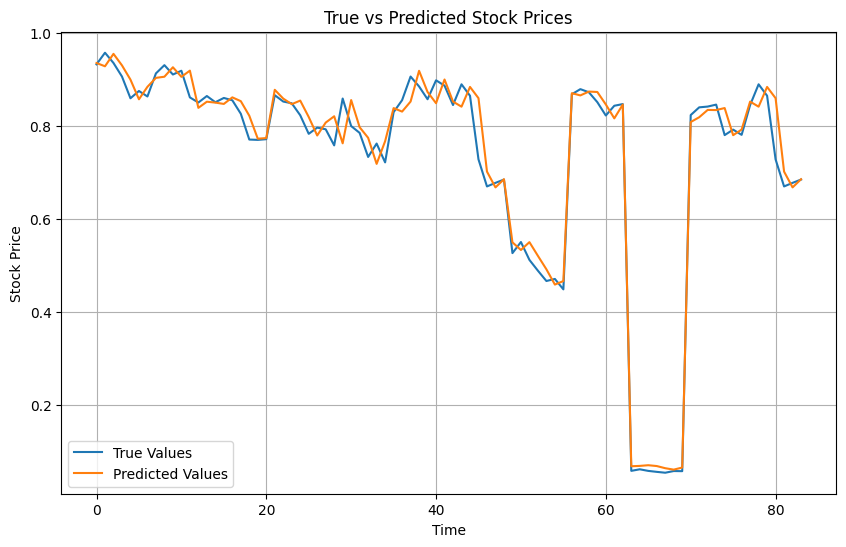

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


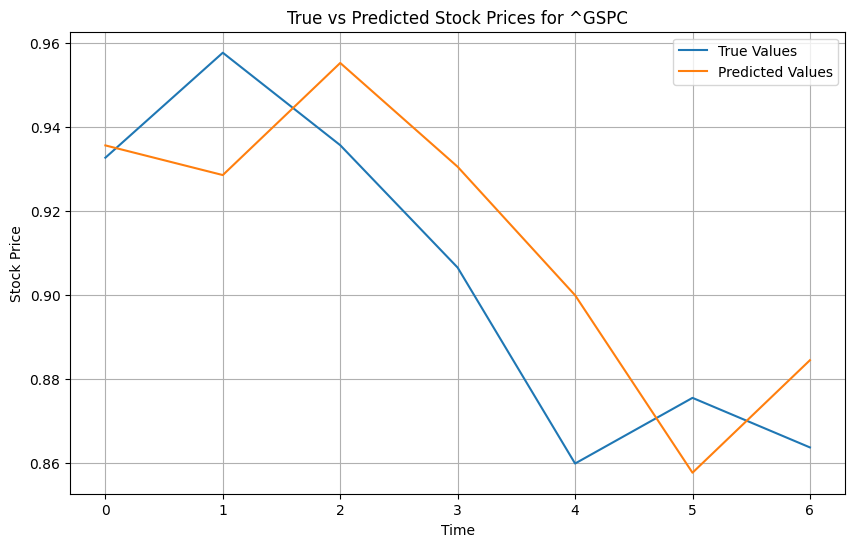

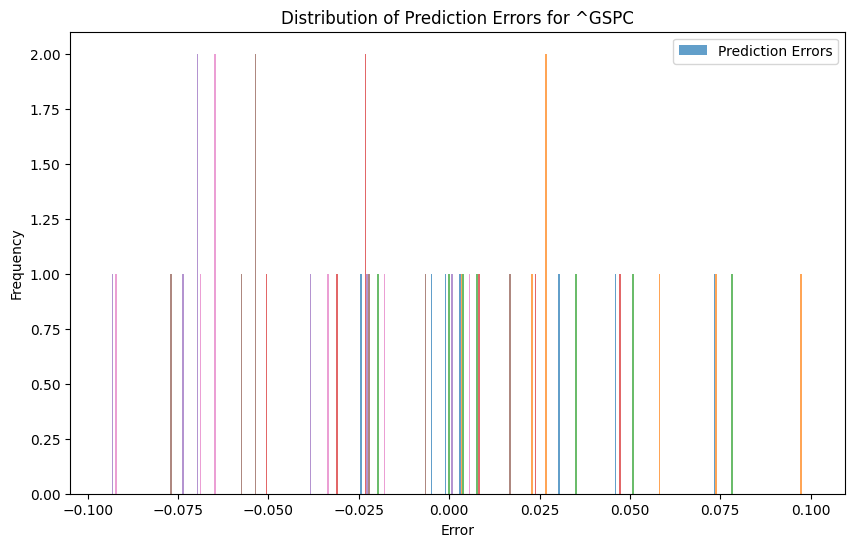

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


C:\Users\ilyaf\AppData\Local\Temp\ipykernel_9032\2459088126.py:153: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_sequence[-1, 3] = next_day_scaled


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2024-08-08 16:01:22,297 - INFO - Predicted prices for ^GSPC next month:
2024-08-08 16:01:22,297 - INFO - Day 1: $5214.04
2024-08-08 16:01:22,297 - INFO - Day 2: $5338.51
2024-08-08 16:01:22,297 - INFO - Day 3: $5396.12
2024-08-08 16:01:22,297 - INFO - Day 4: $5401.05
2024-08-08 16:01:22,297 - INFO - Day 5: $5328.15


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


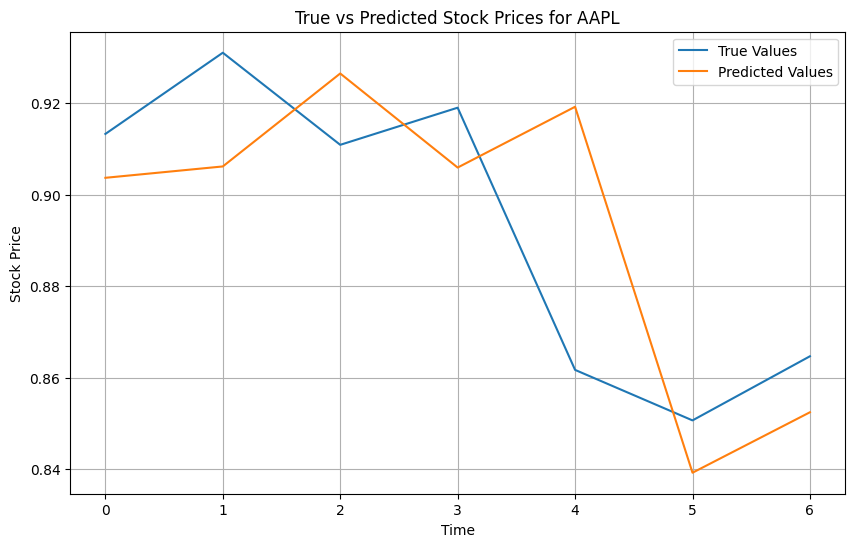

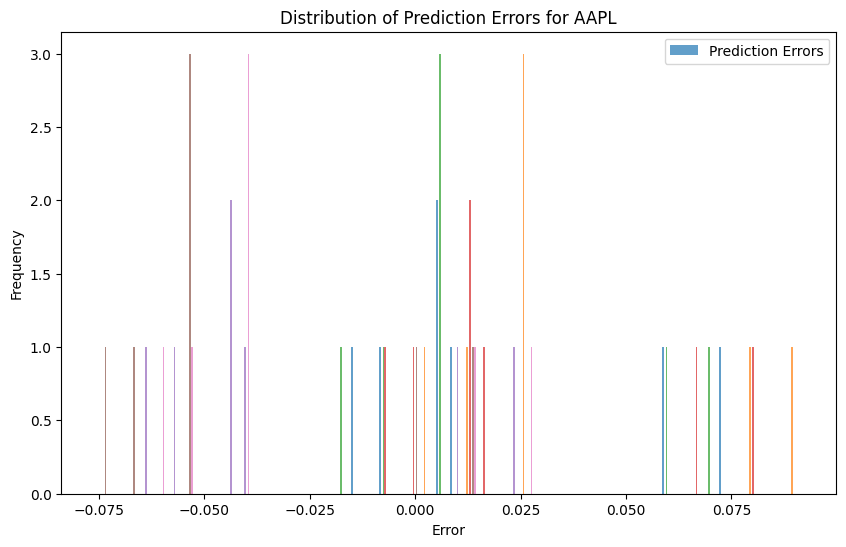

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


C:\Users\ilyaf\AppData\Local\Temp\ipykernel_9032\2459088126.py:153: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_sequence[-1, 3] = next_day_scaled


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


2024-08-08 16:01:23,892 - INFO - Predicted prices for AAPL next month:
2024-08-08 16:01:23,892 - INFO - Day 1: $209.65
2024-08-08 16:01:23,892 - INFO - Day 2: $213.31
2024-08-08 16:01:23,892 - INFO - Day 3: $216.20
2024-08-08 16:01:23,892 - INFO - Day 4: $216.08
2024-08-08 16:01:23,892 - INFO - Day 5: $216.89


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


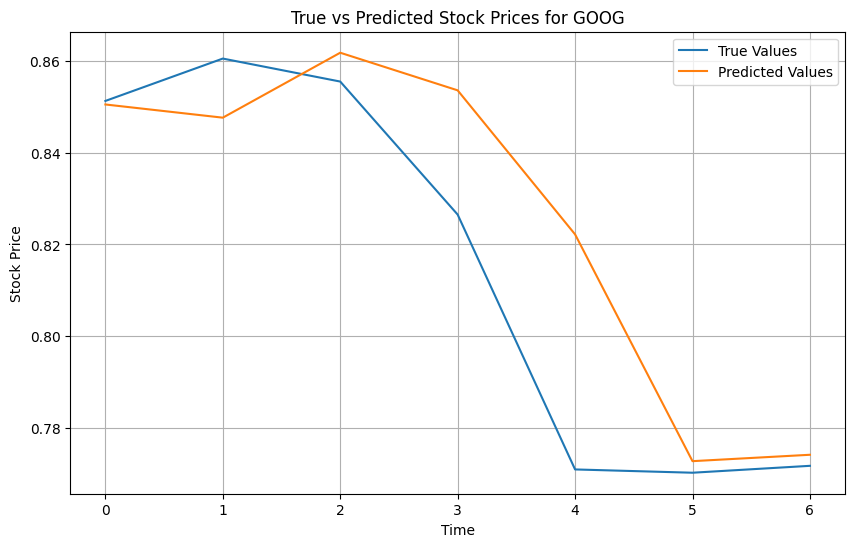

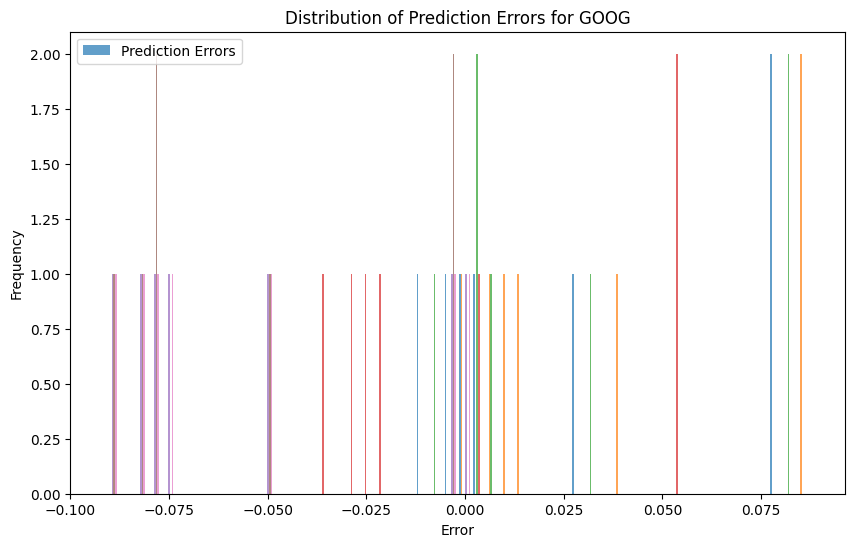

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


C:\Users\ilyaf\AppData\Local\Temp\ipykernel_9032\2459088126.py:153: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_sequence[-1, 3] = next_day_scaled


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2024-08-08 16:01:25,577 - INFO - Predicted prices for GOOG next month:
2024-08-08 16:01:25,577 - INFO - Day 1: $162.20
2024-08-08 16:01:25,577 - INFO - Day 2: $167.12
2024-08-08 16:01:25,577 - INFO - Day 3: $169.55
2024-08-08 16:01:25,577 - INFO - Day 4: $170.27
2024-08-08 16:01:25,577 - INFO - Day 5: $168.12


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


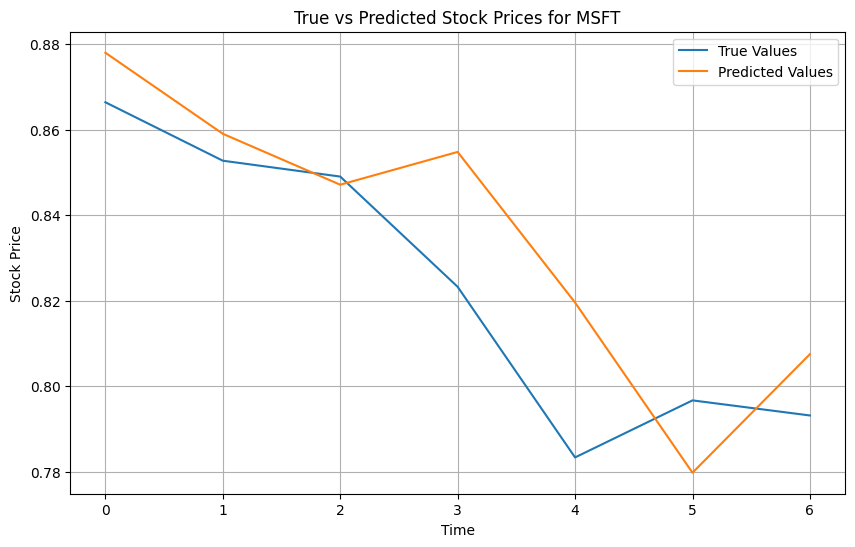

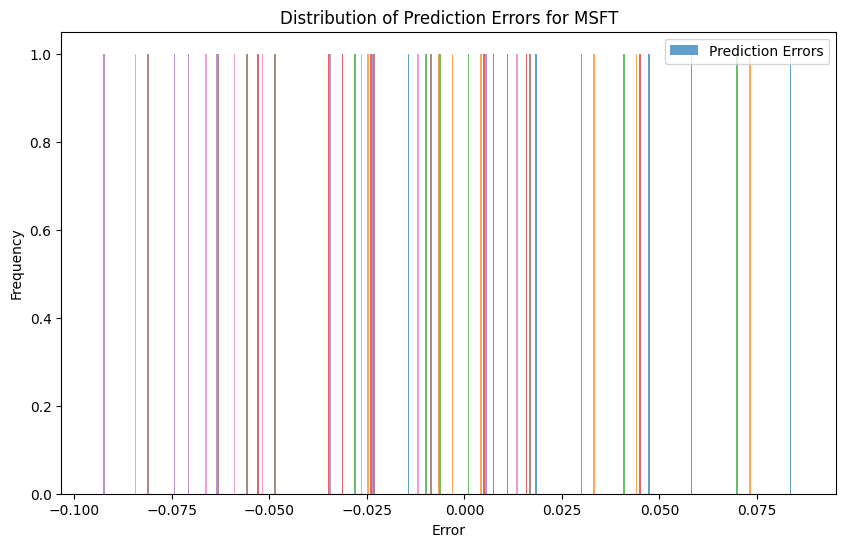

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


C:\Users\ilyaf\AppData\Local\Temp\ipykernel_9032\2459088126.py:153: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_sequence[-1, 3] = next_day_scaled


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2024-08-08 16:01:27,275 - INFO - Predicted prices for MSFT next month:
2024-08-08 16:01:27,275 - INFO - Day 1: $400.19
2024-08-08 16:01:27,275 - INFO - Day 2: $411.22
2024-08-08 16:01:27,275 - INFO - Day 3: $410.48
2024-08-08 16:01:27,275 - INFO - Day 4: $414.09
2024-08-08 16:01:27,275 - INFO - Day 5: $408.93


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


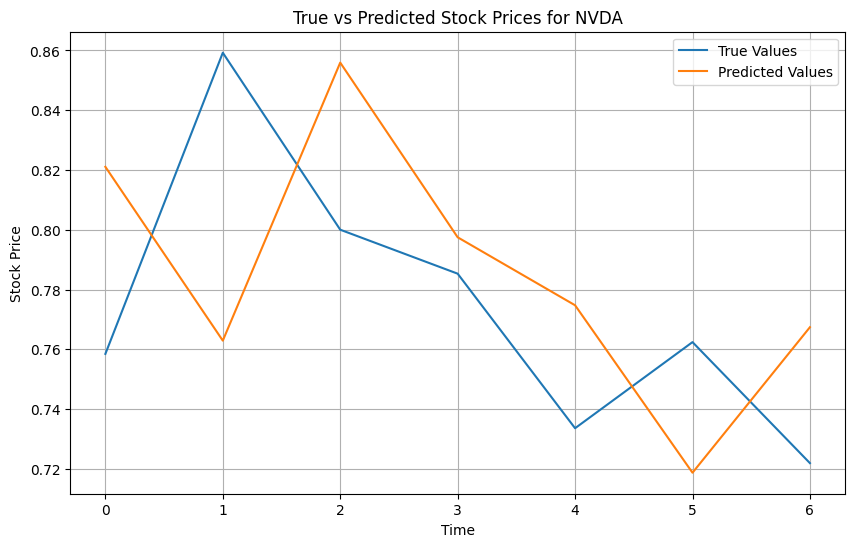

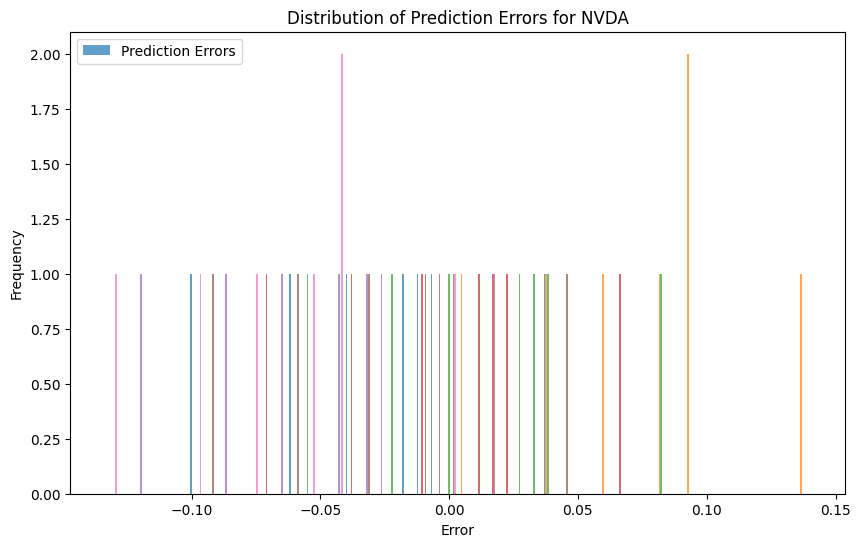

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


C:\Users\ilyaf\AppData\Local\Temp\ipykernel_9032\2459088126.py:153: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_sequence[-1, 3] = next_day_scaled


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2024-08-08 16:01:29,454 - INFO - Predicted prices for NVDA next month:
2024-08-08 16:01:29,454 - INFO - Day 1: $100.38
2024-08-08 16:01:29,454 - INFO - Day 2: $103.52
2024-08-08 16:01:29,454 - INFO - Day 3: $108.30
2024-08-08 16:01:29,454 - INFO - Day 4: $108.85
2024-08-08 16:01:29,454 - INFO - Day 5: $105.39


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


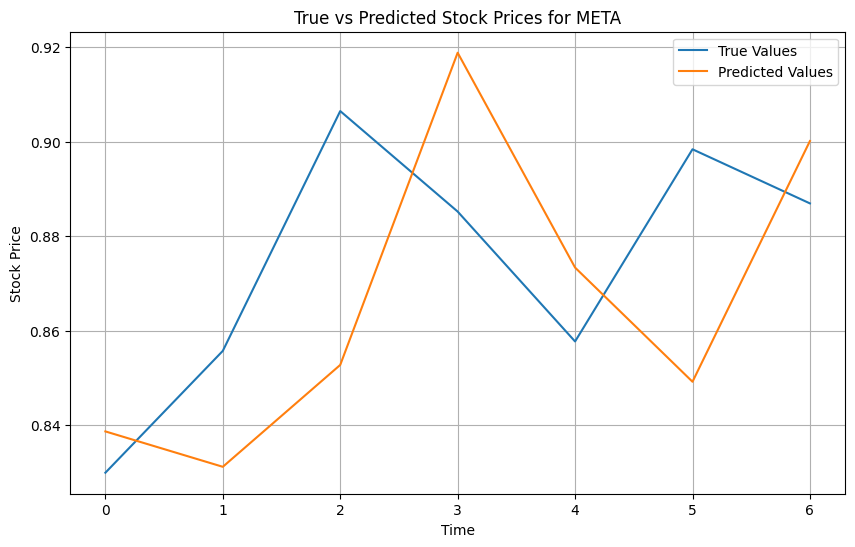

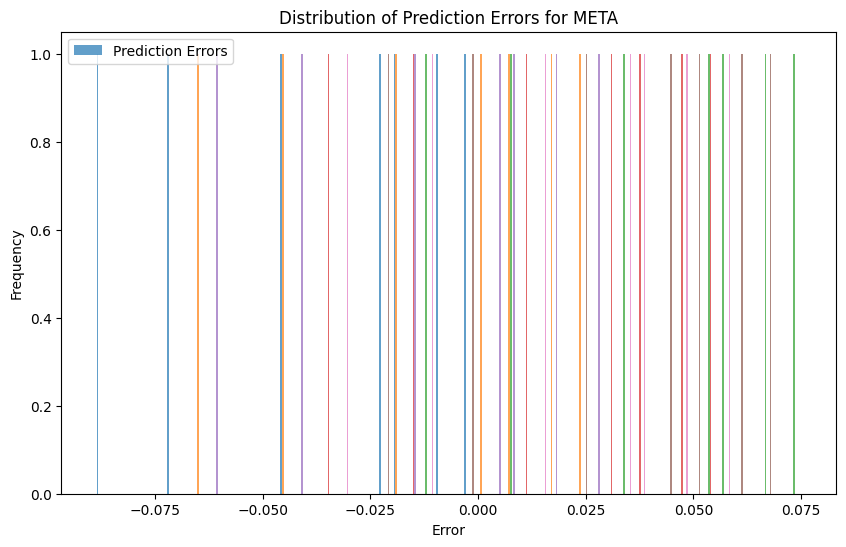

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


C:\Users\ilyaf\AppData\Local\Temp\ipykernel_9032\2459088126.py:153: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_sequence[-1, 3] = next_day_scaled


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2024-08-08 16:01:31,205 - INFO - Predicted prices for META next month:
2024-08-08 16:01:31,205 - INFO - Day 1: $490.54
2024-08-08 16:01:31,205 - INFO - Day 2: $476.02
2024-08-08 16:01:31,205 - INFO - Day 3: $474.85
2024-08-08 16:01:31,205 - INFO - Day 4: $493.36
2024-08-08 16:01:31,205 - INFO - Day 5: $488.07


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


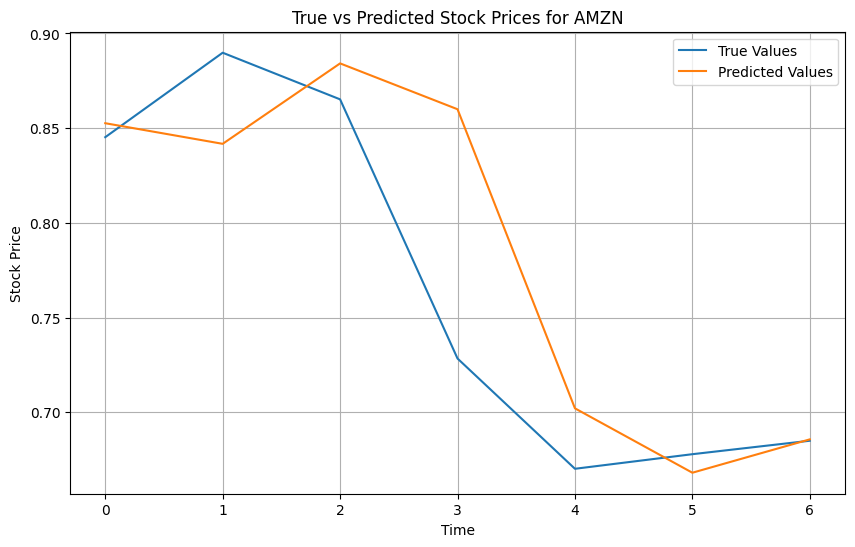

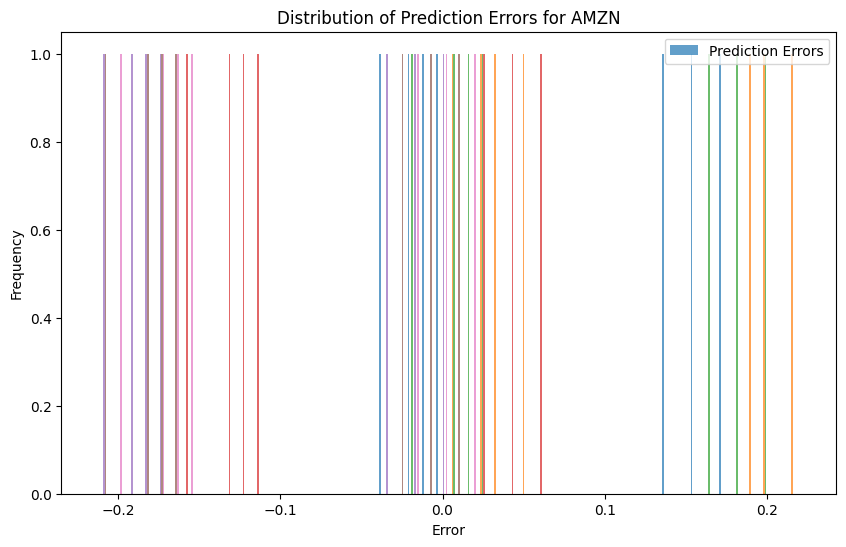

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


C:\Users\ilyaf\AppData\Local\Temp\ipykernel_9032\2459088126.py:153: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_sequence[-1, 3] = next_day_scaled


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


2024-08-08 16:01:32,880 - INFO - Predicted prices for AMZN next month:
2024-08-08 16:01:32,880 - INFO - Day 1: $164.02
2024-08-08 16:01:32,880 - INFO - Day 2: $173.71
2024-08-08 16:01:32,880 - INFO - Day 3: $178.42
2024-08-08 16:01:32,880 - INFO - Day 4: $179.89
2024-08-08 16:01:32,880 - INFO - Day 5: $169.40


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


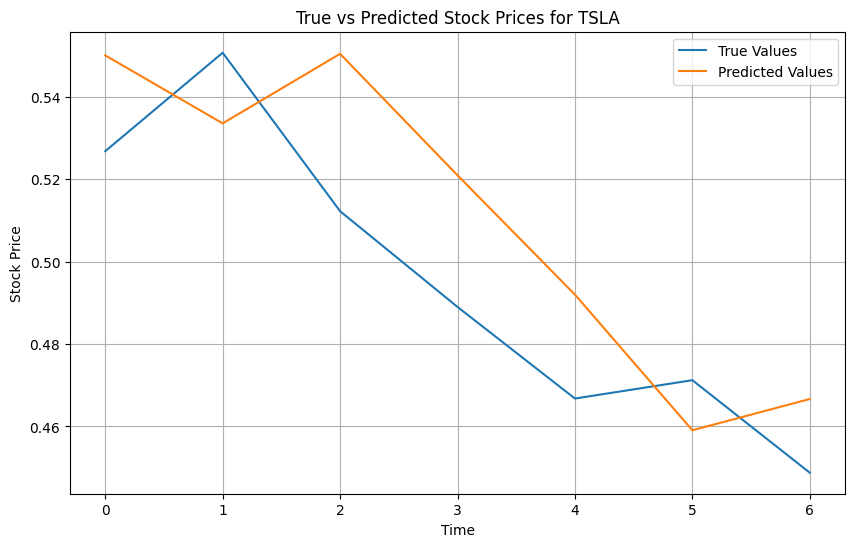

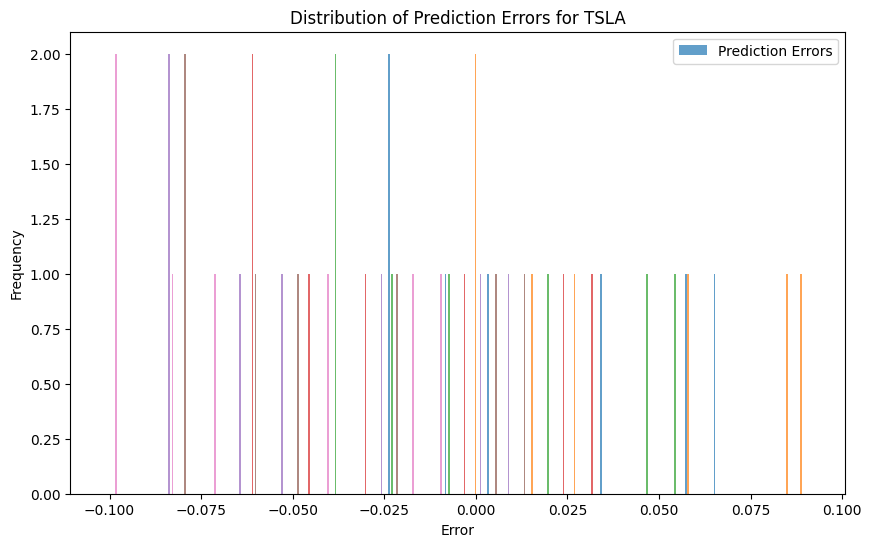

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


C:\Users\ilyaf\AppData\Local\Temp\ipykernel_9032\2459088126.py:153: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_sequence[-1, 3] = next_day_scaled


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2024-08-08 16:01:34,491 - INFO - Predicted prices for TSLA next month:
2024-08-08 16:01:34,491 - INFO - Day 1: $195.04
2024-08-08 16:01:34,491 - INFO - Day 2: $210.54
2024-08-08 16:01:34,491 - INFO - Day 3: $220.59
2024-08-08 16:01:34,491 - INFO - Day 4: $220.38
2024-08-08 16:01:34,491 - INFO - Day 5: $214.18


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


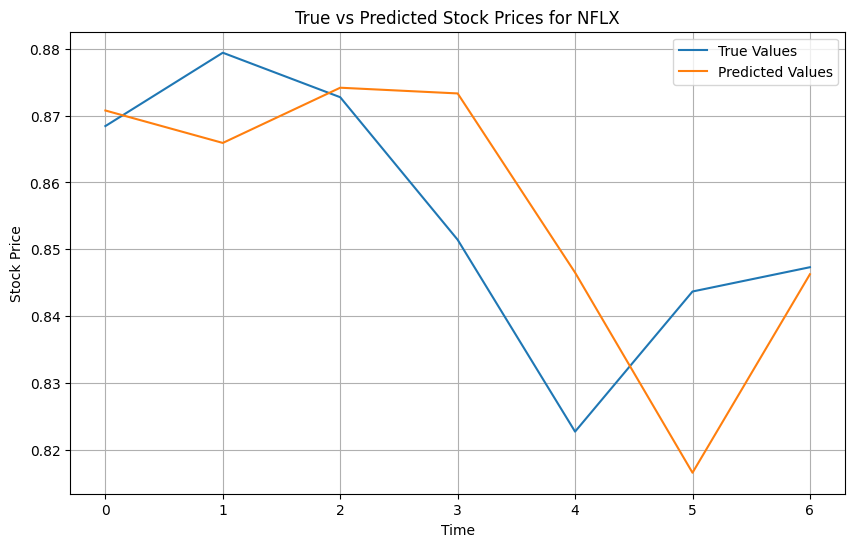

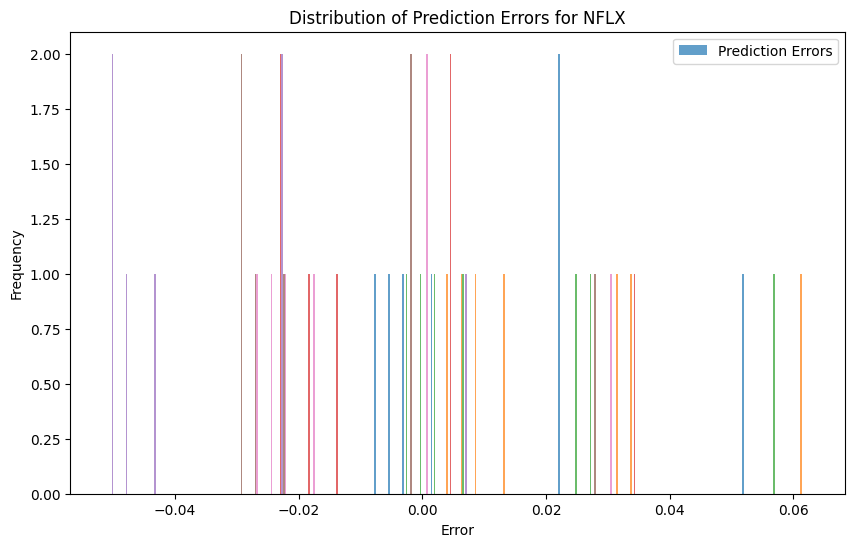

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

C:\Users\ilyaf\AppData\Local\Temp\ipykernel_9032\2459088126.py:153: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_sequence[-1, 3] = next_day_scaled


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


2024-08-08 16:01:36,130 - INFO - Predicted prices for NFLX next month:
2024-08-08 16:01:36,130 - INFO - Day 1: $613.06
2024-08-08 16:01:36,130 - INFO - Day 2: $615.63
2024-08-08 16:01:36,130 - INFO - Day 3: $617.57
2024-08-08 16:01:36,130 - INFO - Day 4: $620.55
2024-08-08 16:01:36,130 - INFO - Day 5: $613.13


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


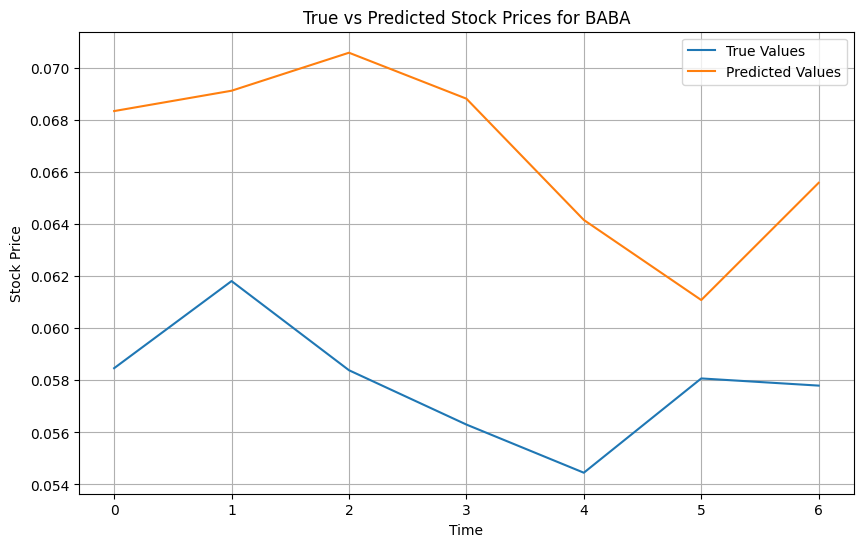

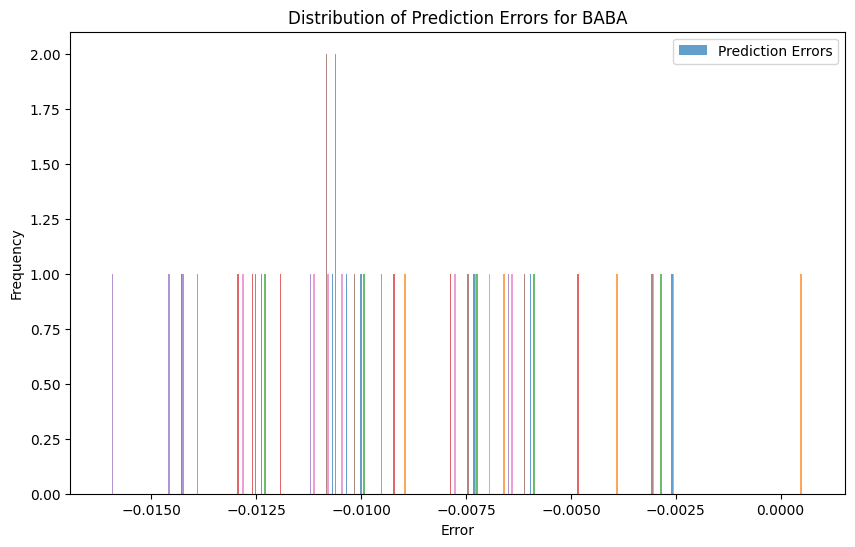

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


C:\Users\ilyaf\AppData\Local\Temp\ipykernel_9032\2459088126.py:153: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_sequence[-1, 3] = next_day_scaled


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


2024-08-08 16:01:37,786 - INFO - Predicted prices for BABA next month:
2024-08-08 16:01:37,786 - INFO - Day 1: $80.45
2024-08-08 16:01:37,786 - INFO - Day 2: $81.38
2024-08-08 16:01:37,786 - INFO - Day 3: $82.43
2024-08-08 16:01:37,786 - INFO - Day 4: $82.80
2024-08-08 16:01:37,786 - INFO - Day 5: $82.21


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


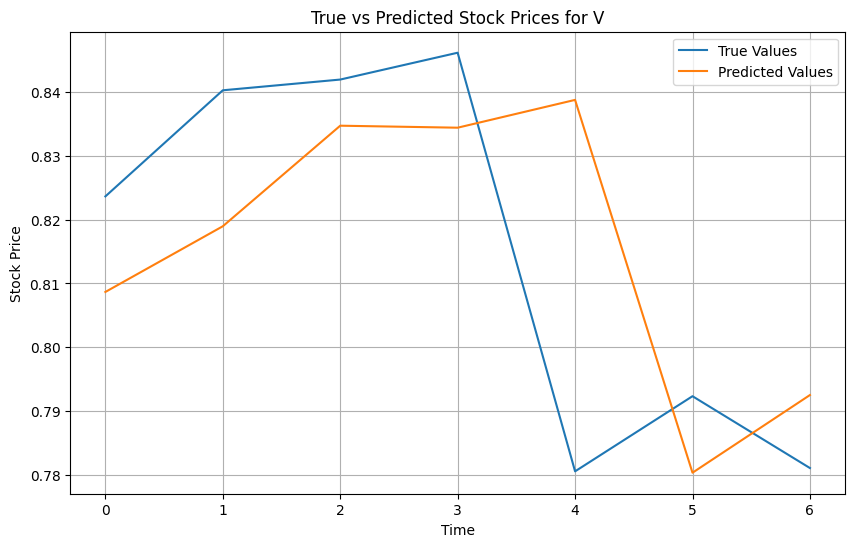

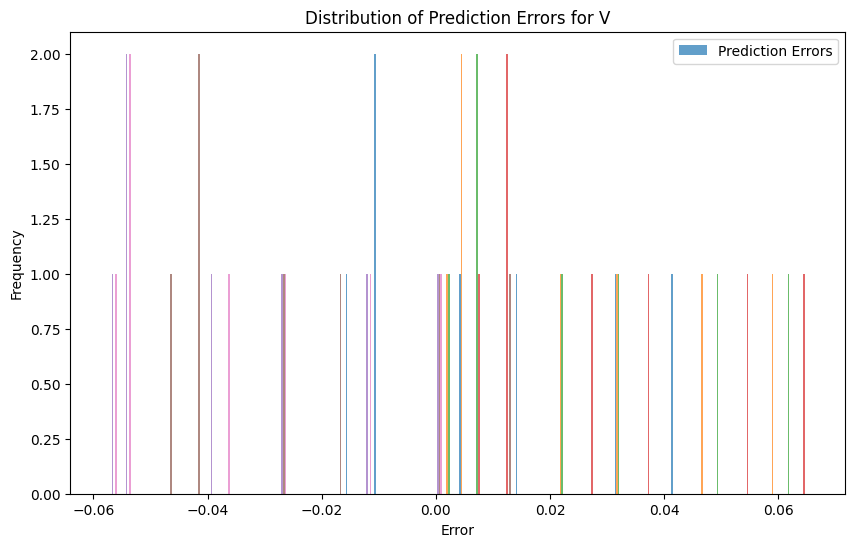

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


C:\Users\ilyaf\AppData\Local\Temp\ipykernel_9032\2459088126.py:153: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_sequence[-1, 3] = next_day_scaled


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


2024-08-08 16:01:39,503 - INFO - Predicted prices for V next month:
2024-08-08 16:01:39,503 - INFO - Day 1: $257.90
2024-08-08 16:01:39,503 - INFO - Day 2: $260.42
2024-08-08 16:01:39,503 - INFO - Day 3: $262.16
2024-08-08 16:01:39,503 - INFO - Day 4: $262.98
2024-08-08 16:01:39,503 - INFO - Day 5: $263.44


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


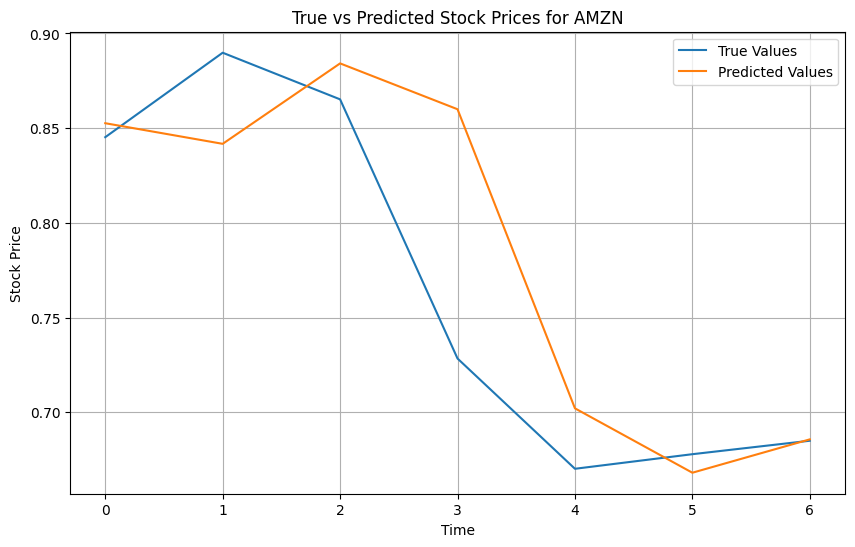

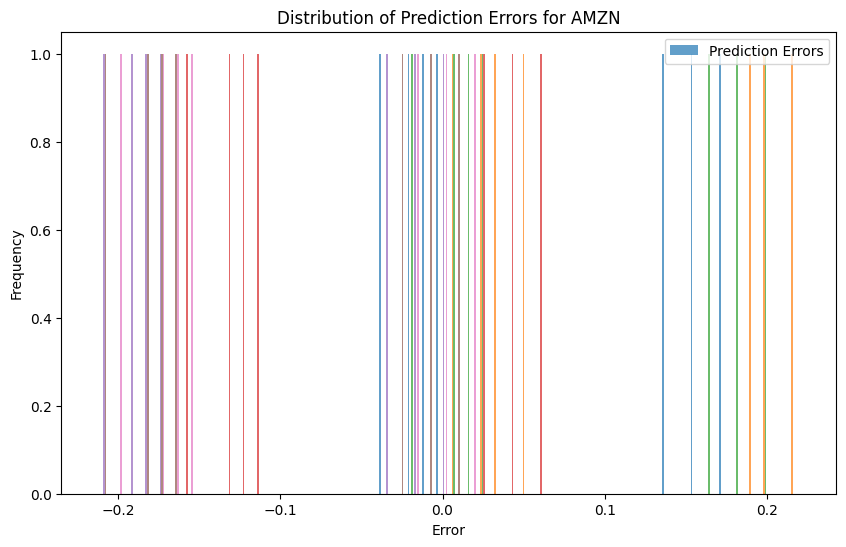

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


C:\Users\ilyaf\AppData\Local\Temp\ipykernel_9032\2459088126.py:153: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_sequence[-1, 3] = next_day_scaled


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2024-08-08 16:01:41,176 - INFO - Predicted prices for AMZN next month:
2024-08-08 16:01:41,176 - INFO - Day 1: $164.02
2024-08-08 16:01:41,176 - INFO - Day 2: $173.71
2024-08-08 16:01:41,176 - INFO - Day 3: $178.42
2024-08-08 16:01:41,176 - INFO - Day 4: $179.89
2024-08-08 16:01:41,176 - INFO - Day 5: $169.40


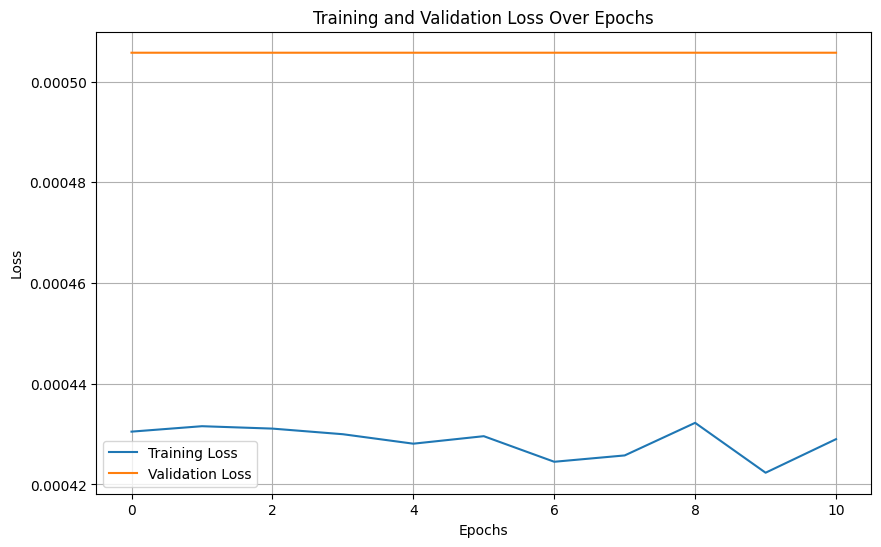

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 7, 256)         │       268,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,421,189 (5.42 MB)

 Trainable params: 473,729 (1.81 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 947,460 (3.61 MB)

In [114]:
if __name__ == "__main__":
    tickers = load_config()["tikets"]
    continue_training = True

    model = StockModel(tickers, continue_training)
    model.train_and_evaluate()
    plot_training_history(model.history)
    model = load_model('../models/stock_model.keras')
    model.summary()